In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd
pd.set_option('display.max_columns', False)

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import xgboost as xgb
import lightgbm as lgbm

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import roc_curve, RocCurveDisplay, classification_report, roc_auc_score, \
                            precision_recall_curve, PrecisionRecallDisplay

import time
import warnings
warnings.filterwarnings('ignore')

# Data Preparation

Cell di bawah ini untuk me-load file csv sampling_healtkathon2022.csv yang disimpan dalam variabel df

In [ ]:
df = pd.read_csv('sampling_healtkathon2022/sampling_healtkathon2022.csv')
df.head()

,id,id_peserta,dati2,typefaskes,usia,jenkel,pisat,tgldatang,tglpulang,jenispel,politujuan,diagfktp,biaya,jenispulang,cbg,kelasrawat,kdsa,kdsp,kdsr,kdsi,kdsd,label
0,165666,486,17,KL,48,P,1.0,2018-07-25T17:00:00.000Z,2018-07-25T17:00:00.000Z,2,THT,L02.8,184300.0,1.0,Q-5-42-0,3,None,None,None,None,None,0
1,1010828,520,17,A,63,L,1.0,2019-05-27T17:00:00.000Z,2019-05-30T17:00:00.000Z,1,NaN,R23.1,10628400.0,1.0,D-4-13-III,1,None,None,None,None,None,0
2,166042,523,17,KL,53,P,1.0,2019-07-16T17:00:00.000Z,2019-07-16T17:00:00.000Z,2,INT,E10.5,187300.0,1.0,Q-5-44-0,3,None,None,None,None,None,0
3,168937,549,17,KL,54,P,1.0,2019-10-17T17:00:00.000Z,2019-10-17T17:00:00.000Z,2,MAT,H54.2,187300.0,1.0,Q-5-44-0,3,None,None,None,None,None,0
4,1005899,549,17,A,53,P,1.0,2018-04-18T17:00:00.000Z,2018-04-18T17:00:00.000Z,2,SAR,M54.5,381600.0,1.0,Q-5-44-0,3,None,None,None,None,None,0


In [ ]:
df.tail()

,id,id_peserta,dati2,typefaskes,usia,jenkel,pisat,tgldatang,tglpulang,jenispel,politujuan,diagfktp,biaya,jenispulang,cbg,kelasrawat,kdsa,kdsp,kdsr,kdsi,kdsd,label
11401877,9983563,8527704,301,B,0,P,4.0,2020-12-30T17:00:00.000Z,2021-01-03T17:00:00.000Z,1,NaN,Z71.8,3645100.0,1.0,P-8-17-I,3,None,None,None,None,None,0
11401878,11053870,8527709,233,A,0,P,4.0,2020-12-30T17:00:00.000Z,2021-01-03T17:00:00.000Z,1,NaN,P59.9,12273200.0,1.0,P-8-13-II,2,None,None,None,None,None,0
11401879,7461049,8527751,118,B,0,L,4.0,2020-12-30T17:00:00.000Z,2021-01-06T17:00:00.000Z,1,NaN,P24.8,4099000.0,1.0,P-8-08-I,3,None,None,None,None,None,0
11401880,1075162,8527853,101,SC,0,L,5.0,2020-12-29T17:00:00.000Z,2020-12-31T17:00:00.000Z,1,NaN,P03,3992400.0,1.0,P-8-08-I,3,None,None,None,None,None,0
11401881,102794,8527876,12,SD,0,P,4.0,2020-12-29T17:00:00.000Z,2020-12-31T17:00:00.000Z,1,NaN,P21.1,1624900.0,1.0,P-8-16-I,3,None,None,None,None,None,0


In [ ]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11401882 entries, 0 to 11401881
Data columns (total 22 columns):
 #   Column       Non-Null Count     Dtype  
---  ------       --------------     -----  
 0   id           11401882 non-null  int64  
 1   id_peserta   11401882 non-null  int64  
 2   dati2        11401882 non-null  int64  
 3   typefaskes   11401882 non-null  object 
 4   usia         11401882 non-null  int64  
 5   jenkel       11401833 non-null  object 
 6   pisat        11401692 non-null  float64
 7   tgldatang    11401882 non-null  object 
 8   tglpulang    11401882 non-null  object 
 9   jenispel     11401882 non-null  int64  
 10  politujuan   7360427 non-null   object 
 11  diagfktp     11399352 non-null  object 
 12  biaya        11344067 non-null  float64
 13  jenispulang  11401843 non-null  float64
 14  cbg          11401882 non-null  object 
 15  kelasrawat   11401882 non-null  int64  
 16  kdsa         11203212 non-null  object 
 17  kdsp         11204875 non

 cell di bawah untuk load dataset sampling_healthkathon2022_diagnosa.csv yang disimpan dalam variabel df_diagnosa

In [ ]:
df_diagnosa = pd.read_csv('sampling_healthkathon2022_diagnosa/sampling_healthkathon2022_diagnosa.csv') 
df_diagnosa.head(2)

,id,diag,levelid
0,6,O06.9,1
1,57,J02.9,1


In [ ]:
df_proc = pd.read_csv('sampling_healthkathon2022_procedure/sampling_healthkathon2022_procedure.csv')
df_proc.head()

,id,proc
0,6,90.59
1,6,69.01
2,6,88.78
3,27,90.59
4,27,88.78


In [ ]:
df_proc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12202871 entries, 0 to 12202870
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   proc    object
dtypes: int64(1), object(1)
memory usage: 186.2+ MB


cell di bawah ini untuk memvisualisasikan banyaknya null dataset tiap kolom dari dataframe df dan df_diagnosa

In [ ]:
def plot_null(df):
  plt.figure(figsize=(20,5))
  ax = sns.barplot(x=df.isna().sum().sort_values().index, 
                   y=df.isna().sum().sort_values().values)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  ax.bar_label(ax.containers[0])
  plt.show()

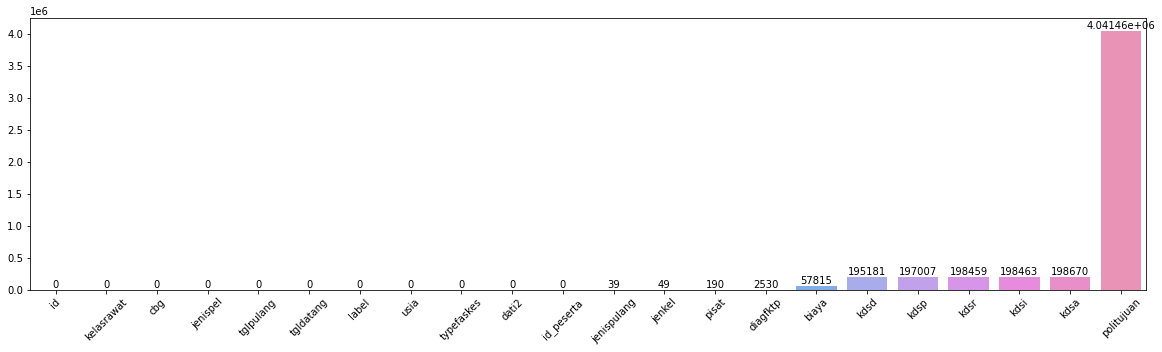

In [ ]:
plot_null(df)

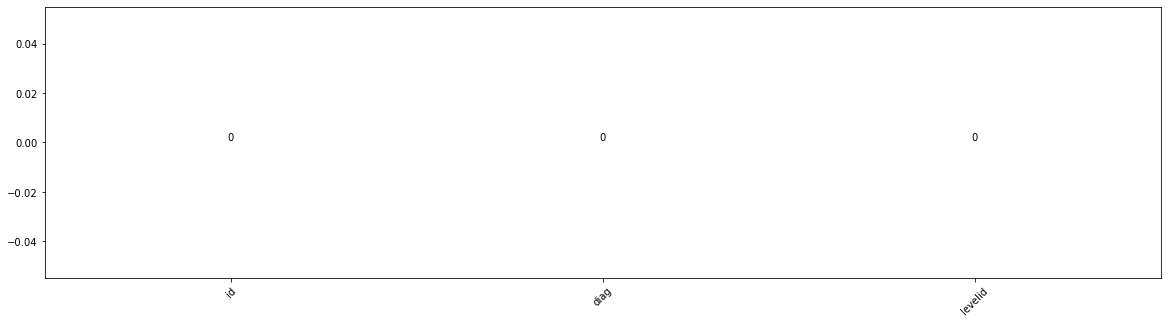

In [ ]:
plot_null(df_diagnosa)

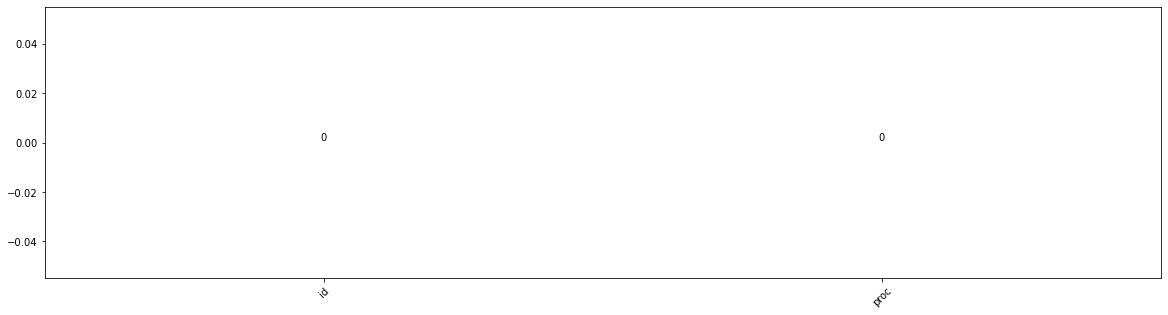

In [ ]:
plot_null(df_proc)

cell di bawah ini untuk mengetahui jumlah baris/record data yang similar dari dataset df 

In [ ]:
df.duplicated().sum()

14

cell di bawah ini untuk mengetahui jumlah baris/record data yang similar dari dataset df_diagnosa

In [ ]:
df_diagnosa.duplicated().sum()

56

In [ ]:
df_proc.duplicated().sum()

47

# Data Cleaning

## Clean df

Cell di bawah ini adalah untuk mengetahui karakter-karakter unik dari masing-masing fitur kategorik dataset df

In [ ]:
df.typefaskes.unique()

array(['KL', 'A', 'SD', 'KI', 'C', 'B', 'I2', 'SC', 'SB', 'KJ', 'I3',
       'KM', 'I4', 'HD', 'KU', 'GD', 'KO', 'KP', 'D', 'KB', 'KG', 'I1',
       'KT', 'KC', 'SA', 'KK'], dtype=object)

In [ ]:
df.politujuan.unique()

array(['THT', nan, 'INT', 'MAT', 'SAR', 'IGD', 'GND', 'JAN', 'KLT', 'IRM',
       'BED', 'PAR', '010', 'UGD', 'GIG', 'URO', 'ORT', 'END', 'OBG',
       '100', 'RAT', 'ANA', 'HDL', 'JIW', '013', 'BDM', '007', 'FIS',
       '028', '024', '005', '077', '021', '170', '018', 'JWD', 'KON',
       'GP1', '017', 'GIN', '135', '008', 'ANT', '169', 'PNM', '140',
       '015', 'BSY', 'PTD', '133', 'IPD', 'GPR', '109', 'HEM', 'REM',
       'PSI', '138', 'TUM', 'GOR', 'LAI', '132', '006', 'RAD', 'KDN',
       'BTK', 'AND', '137', 'CAN', '067', 'KEM', 'GER', '032', '147',
       '134', '004', '097', '157', '030', '096', 'BDP', 'BDA', '163',
       'OKM', '168', '022', 'GIZ', '139', 'PSK', '068', 'ALG', '034',
       'GAS', '143', '023', 'JWA', '152', 'IKA', 'DRH', 'HIV', 'igd',
       '071', 'BDO', '081', '025', '027', 'HAM', 'DBM', '040', '162',
       '070', '009', '160', '072', '142', '020', 'int', 'bed', '029',
       '075', 'NUK', 'PAA', '033', '031', '074', '014', '084', 'EKG',
       '141', '

In [ ]:
df.diagfktp.unique()

array(['L02.8', 'R23.1', 'E10.5', ..., 'm77.0', 'S45.8', 'E73.1'],
      dtype=object)

In [ ]:
df.jenkel.unique()

array(['P', 'L', nan], dtype=object)

In [ ]:
df.cbg.unique()

array(['Q-5-42-0', 'D-4-13-III', 'Q-5-44-0', ..., 'V-3-10-0', 'V-2-10-0',
       'J-2-31-0'], dtype=object)

In [ ]:
df.kdsa.unique()

array(['None', nan, 'SF-4-10-III', 'SF-4-10-I', 'SF-4-13-III',
       'SF-4-10-II', 'SF-4-10-IV', 'SF-4-15-IV', 'SF-4-13-II',
       'SF-4-16-IV', 'SF-4-10-X', 'SF-4-16-III', 'SF-4-16-II',
       'SF-4-13-IV', 'SF-4-15-II', 'SF-4-11-IV', 'SF-4-13-X', 'SF-4-16-I',
       'SF-4-15-III', 'SF-4-13-I', 'SF-4-15-I', 'SF-4-16-X', 'SF-4-11-I',
       'ST-4-11-II', 'SA-4-14-X', 'SF-4-11-II', 'SF-4-19-I', 'SF-4-12-II',
       'SF-4-11-III', 'SF-4-19-IV', 'SA-4-14-II', 'SF-4-19-II',
       'SF-4-19-III', 'SA-4-14-I', 'ST-1-10-III', 'SF-4-18-I',
       'SF-4-15-X'], dtype=object)

In [ ]:
df.kdsp.unique()

array(['None', nan, 'YY-10-III', 'YY-09-III', 'YY-01-II', 'YY-02-III',
       'YY-05-III', 'YY-08-III', 'YY-06-III', 'YY-07-III', 'YY-11-III',
       'YY-03-III', 'YY-04-III', 'YY-12-III'], dtype=object)

In [ ]:
df.kdsr.unique()

array(['None', nan, 'RR-04-III', 'RR-02-II', 'RR-01-II', 'RR-05-III',
       'RR-03-III'], dtype=object)

In [ ]:
df.kdsi.unique()

array(['None', 'II-02-III', nan, 'II-01-III', 'II-03-III'], dtype=object)

In [ ]:
df.kdsd.unique()

array(['None', nan, 'DD-01-I', 'DD-05-II', 'DD-07-II', 'DD-06-II',
       'DD-04-II', 'DD-09-II', 'DD-10-II', 'DD-02-II', 'DD-03-II',
       'DD-08-II', 'DD-11-II'], dtype=object)

Cell di bawah ini adalah untuk menyamakan format karakter pada fitur kategorik dataset df, yaitu string tanpa whitespaces dan berhuruf kapital

In [ ]:
for obj_col in ['typefaskes', 'jenkel', 'politujuan', 'diagfktp', 'cbg', 'kdsa', 'kdsp', 'kdsr', 'kdsi', 'kdsd']:
    df[obj_col] = df[obj_col].str.strip()
    df[obj_col] = df[obj_col].str.upper()
    
    print(obj_col, 'DONE!')

typefaskes DONE!
jenkel DONE!
politujuan DONE!
diagfktp DONE!
cbg DONE!
kdsa DONE!
kdsp DONE!
kdsr DONE!
kdsi DONE!
kdsd DONE!


Cell di bawah ini untuk menghapus baris-baris duplikasi, dataset tanpa baris duplikasi disimpan dalam variabel df_no_dup

In [ ]:
df_no_dup = df.drop_duplicates(ignore_index=True).copy()
df_no_dup.shape

(11401868, 22)

In [ ]:
df_no_dup.drop('politujuan', axis=1, inplace=True)

Cell di bawah adalah syntax untuk menghandle missing value, dengan ketentuan sebagai berikut ;
1. Untuk missing value pada kolom-kolom data bertipe kategorik selain biaya
    - ubah menjadi modus kolom kategorik tsb.
2. Untuk missing value pada Kolom data biaya
    - ubah menjadi mean biaya tsb.
3. Untuk data ke-i yang ada pada kolom-kolom kategorik
    - Tidak diubah 

Setelah melalui proses handle missing value, data diubah kembali ke bentuk dataframe menggunakan module to_df

In [ ]:
class to_df(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, arr):
        return self
    def transform(self, arr):
        return pd.DataFrame(arr, columns=['jenispulang', 'jenkel', 'pisat', 'diagfktp', 
                                          'kdsa', 'kdsp', 'kdsr', 'kdsi', 'kdsd', 'biaya', 'id', 'id_peserta', 
                                          'dati2', 'typefaskes', 'usia', 'tgldatang', 'tglpulang', 
                                          'jenispel', 'cbg', 'kelasrawat', 'label'])

impute = ColumnTransformer([
    ('most_freq', 
     SimpleImputer(strategy='most_frequent'), 
     ['jenispulang', 'jenkel', 'pisat', 'diagfktp', 
      'kdsa', 'kdsp', 'kdsr', 'kdsi', 'kdsd']),
    
    ('mean',
    SimpleImputer(strategy='median'),
    ['biaya'])
], remainder='passthrough')

impute.fit(df_no_dup)

ColumnTransformer(remainder='passthrough',
                  transformers=[('most_freq',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['jenispulang', 'jenkel', 'pisat', 'diagfktp',
                                  'kdsa', 'kdsp', 'kdsr', 'kdsi', 'kdsd']),
                                ('mean', SimpleImputer(strategy='median'),
                                 ['biaya'])])

In [ ]:
df_no_dup_prepared = impute.transform(df_no_dup)
df_no_dup_prepared = to_df().transform(df_no_dup_prepared)
df_no_dup_prepared.head()

,jenispulang,jenkel,pisat,diagfktp,kdsa,kdsp,kdsr,kdsi,kdsd,biaya,id,id_peserta,dati2,typefaskes,usia,tgldatang,tglpulang,jenispel,cbg,kelasrawat,label
0,1.0,P,1.0,L02.8,NONE,NONE,NONE,NONE,NONE,184300.0,165666,486,17,KL,48,2018-07-25T17:00:00.000Z,2018-07-25T17:00:00.000Z,2,Q-5-42-0,3,0
1,1.0,L,1.0,R23.1,NONE,NONE,NONE,NONE,NONE,10628400.0,1010828,520,17,A,63,2019-05-27T17:00:00.000Z,2019-05-30T17:00:00.000Z,1,D-4-13-III,1,0
2,1.0,P,1.0,E10.5,NONE,NONE,NONE,NONE,NONE,187300.0,166042,523,17,KL,53,2019-07-16T17:00:00.000Z,2019-07-16T17:00:00.000Z,2,Q-5-44-0,3,0
3,1.0,P,1.0,H54.2,NONE,NONE,NONE,NONE,NONE,187300.0,168937,549,17,KL,54,2019-10-17T17:00:00.000Z,2019-10-17T17:00:00.000Z,2,Q-5-44-0,3,0
4,1.0,P,1.0,M54.5,NONE,NONE,NONE,NONE,NONE,381600.0,1005899,549,17,A,53,2018-04-18T17:00:00.000Z,2018-04-18T17:00:00.000Z,2,Q-5-44-0,3,0


Cell di bawah ini digunakan untuk menghandle nilai dari kolom diagfktp yang memiliki format penamaan berbeda-beda, syntax di bawah ini adalah untuk ;
* mengubah bentuk penamaan diagfktp menjadi 3 digit huruf awal (sesuai format penamaan subgrup pada ICD-10), dengan aturan :
    - Slice diagfktp menjadi 2 digit angka index ke-1 dan ke-2
    - Jika kedua digit tersebut bukan integer, maka append dalam list diagfktp_other, untuk selanjutnya dilakukan prosedur pembenaran nilai menjadi integer dan memiliki inisial yang sesuai ICD-10,
    - Jika tidak bernilai, ubah ke modus diagfktp

In [ ]:
p = df_no_dup_prepared.diagfktp
q = p.str.slice(1,3)

diagfktp_other = []
for i in q.index.values:
    try:
        int(q[i])
    except:
        diagfktp_other.append(p[i])
    
    if i%10**6 == 0:
        print('i =', i, 'DONE!')

diagfktp_other = np.array(diagfktp_other)
diagfktp_other = np.unique(diagfktp_other)

i = 0 DONE!
i = 1000000 DONE!
i = 2000000 DONE!
i = 3000000 DONE!
i = 4000000 DONE!
i = 5000000 DONE!
i = 6000000 DONE!
i = 7000000 DONE!
i = 8000000 DONE!
i = 9000000 DONE!
i = 10000000 DONE!
i = 11000000 DONE!


In [ ]:
diagfktp_other

array(['-', '--', '.', '02.31', '34.89', '==', 'CORPUS', 'FEBRIS',
       'GASTRI', 'H8.14', 'NONE', 'UNDEFINED', 'ZO3.9'], dtype='<U9')

In [ ]:
df_no_dup_prepared.loc[df_no_dup_prepared.diagfktp == 'H8.14', 'diagfktp'] = 'H81.4'
df_no_dup_prepared[df_no_dup_prepared.diagfktp == 'H81.4']

,jenispulang,jenkel,pisat,diagfktp,kdsa,kdsp,kdsr,kdsi,kdsd,biaya,id,id_peserta,dati2,typefaskes,usia,tgldatang,tglpulang,jenispel,cbg,kelasrawat,label
82,1.0,P,3.0,H81.4,NONE,NONE,NONE,NONE,NONE,1669900.0,66871,4100,9,SD,48,2019-05-26T17:00:00.000Z,2019-05-28T17:00:00.000Z,1,U-4-11-I,1,0
199,5.0,L,1.0,H81.4,NONE,NONE,NONE,NONE,NONE,192700.0,152390,11121,17,SC,74,2020-03-08T17:00:00.000Z,2020-03-08T17:00:00.000Z,2,Q-5-44-0,3,0
202,1.0,P,1.0,H81.4,NONE,NONE,NONE,NONE,NONE,185500.0,141650,11286,17,KI,67,2020-01-02T17:00:00.000Z,2020-01-02T17:00:00.000Z,2,Q-5-44-0,3,0
264,1.0,L,1.0,H81.4,NONE,NONE,NONE,NONE,NONE,2438000.0,1562,15500,1,SD,71,2018-10-15T17:00:00.000Z,2018-10-18T17:00:00.000Z,1,I-4-17-I,1,0
309,1.0,L,1.0,H81.4,NONE,NONE,NONE,NONE,NONE,1669900.0,47,19098,1,SD,57,2018-01-29T17:00:00.000Z,2018-01-31T17:00:00.000Z,1,U-4-11-I,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11394746,1.0,L,1.0,H81.4,NONE,NONE,NONE,NONE,NONE,181400.0,9542891,8060031,214,C,58,2019-08-29T17:00:00.000Z,2019-08-29T17:00:00.000Z,2,Q-5-44-0,3,0
11394823,1.0,P,1.0,H81.4,NONE,NONE,NONE,NONE,NONE,192100.0,5135214,8064418,54,SC,70,2020-07-02T17:00:00.000Z,2020-07-02T17:00:00.000Z,2,Q-5-44-0,3,0
11396077,1.0,P,3.0,H81.4,NONE,NONE,NONE,NONE,NONE,190400.0,4273540,8141140,221,SC,52,2020-11-18T17:00:00.000Z,2020-11-18T17:00:00.000Z,2,Q-5-44-0,3,0
11396282,1.0,L,2.0,H81.4,NONE,NONE,NONE,NONE,NONE,1351100.0,3352051,8155912,179,SC,65,2019-11-07T17:00:00.000Z,2019-11-11T17:00:00.000Z,1,U-4-11-I,3,0


In [ ]:
df_no_dup_prepared.loc[df_no_dup_prepared.diagfktp == 'ZO3.9', 'diagfktp'] = 'Z03.9'
df_no_dup_prepared[df_no_dup_prepared.diagfktp == 'Z03.9']

,jenispulang,jenkel,pisat,diagfktp,kdsa,kdsp,kdsr,kdsi,kdsd,biaya,id,id_peserta,dati2,typefaskes,usia,tgldatang,tglpulang,jenispel,cbg,kelasrawat,label
624,1.0,P,1.0,Z03.9,NONE,NONE,NONE,NONE,NONE,196800.0,5858489,36735,458,C,25,2019-08-28T17:00:00.000Z,2019-08-28T17:00:00.000Z,2,F-5-14-0,3,0
637,1.0,L,2.0,Z03.9,NONE,NONE,NONE,NONE,NONE,183300.0,7661930,37621,136,B,53,2020-06-26T17:00:00.000Z,2020-06-26T17:00:00.000Z,2,Q-5-44-0,3,0
654,1.0,L,1.0,Z03.9,NONE,NONE,NONE,NONE,NONE,4120300.0,5615411,38513,69,B,57,2020-04-02T17:00:00.000Z,2020-04-23T17:00:00.000Z,1,N-4-12-II,3,0
670,1.0,P,1.0,Z03.9,NONE,NONE,NONE,NONE,NONE,5308500.0,1396113,39240,112,B,61,2020-01-08T17:00:00.000Z,2020-01-13T17:00:00.000Z,1,G-4-21-II,2,0
950,1.0,L,1.0,Z03.9,NONE,NONE,NONE,NONE,NONE,26469700.0,3704501,53204,38,A,85,2018-12-18T17:00:00.000Z,2018-12-28T17:00:00.000Z,1,N-1-11-II,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11400978,1.0,P,4.0,Z03.9,NONE,NONE,NONE,NONE,NONE,3426200.0,6942104,8468056,115,SC,0,2020-10-13T17:00:00.000Z,2020-10-15T17:00:00.000Z,1,P-8-17-I,3,0
11401050,1.0,L,4.0,Z03.9,NONE,NONE,NONE,NONE,NONE,3426200.0,6942141,8473558,115,SC,0,2020-10-20T17:00:00.000Z,2020-10-22T17:00:00.000Z,1,P-8-17-I,3,0
11401156,1.0,P,4.0,Z03.9,NONE,NONE,NONE,NONE,NONE,3426200.0,6942186,8480652,115,SC,0,2020-10-30T17:00:00.000Z,2020-11-01T17:00:00.000Z,1,P-8-17-I,3,0
11401407,1.0,L,4.0,Z03.9,NONE,NONE,NONE,NONE,NONE,5034500.0,5273184,8496723,55,C,0,2020-11-19T17:00:00.000Z,2020-11-20T17:00:00.000Z,1,P-8-13-I,3,0


In [ ]:
df_no_dup_prepared.diagfktp.value_counts()

Z09.8     413988
R50.9     347215
P03.4     207838
Z03.8     202092
K30       184073
           ...  
X17.9          1
Y62.0          1
M89.57         1
Z001           1
E73.1          1
Name: diagfktp, Length: 15382, dtype: int64

In [ ]:
diagfktp_other = np.delete(diagfktp_other, 9)
diagfktp_other = np.delete(diagfktp_other, -1)

for val in diagfktp_other:
    df_no_dup_prepared.loc[df_no_dup_prepared.diagfktp == val, 'diagfktp'] = 'Z09.8'
    
    print(val, 'DONE!')

- DONE!
-- DONE!
. DONE!
02.31 DONE!
34.89 DONE!
== DONE!
CORPUS DONE!
FEBRIS DONE!
GASTRI DONE!
NONE DONE!
UNDEFINED DONE!


Cell di bawah ini digunakan untuk menghandle nilai dari kolom diagfktp yang memiliki format penamaan berbeda-beda, syntax di bawah ini adalah untuk ;
* mengubah bentuk penamaan diagfktp menjadi 1 digit huruf awal (sesuai format penamaan grup pada ICD-10), dengan aturan :
    - Slice diagfktp menjadi 1 karakter huruf awal
    - Jika karakter tersebut merupakan integer, maka append dalam list diagfktp_other (berdasarkan ICD-10, karakter pertama seharusnya adalah berupa string), untuk selanjutnya dilakukan prosedur pembenaran nilai menjadi integer dan memiliki inisial yang sesuai ICD-10,
    - Jika tidak bernilai, ubah ke modus diagfktp

In [ ]:
p = df_no_dup_prepared.diagfktp
q = p.str.slice(0,1)

diagfktp_other = []
for i in q.index.values:
    if i%10**6 == 0:
        print('i =', i, 'running...')
        
    try:
        int(q[i])
        diagfktp_other.append(p[i])
    except:
        continue

diagfktp_other = np.array(diagfktp_other)
diagfktp_other = np.unique(diagfktp_other)
diagfktp_other

i = 0 running...
i = 1000000 running...
i = 2000000 running...
i = 3000000 running...
i = 4000000 running...
i = 5000000 running...
i = 6000000 running...
i = 7000000 running...
i = 8000000 running...
i = 9000000 running...
i = 10000000 running...
i = 11000000 running...


array(['0001217347', '0001262881', '03'], dtype='<U10')

In [ ]:
for val in diagfktp_other:
    df_no_dup_prepared.loc[df_no_dup_prepared.diagfktp == val, 'diagfktp'] = 'Z09.8'
    
    print(val, 'DONE!')

0001217347 DONE!
0001262881 DONE!
03 DONE!


In [ ]:
df_no_dup_prepared['diagfktp'] = df_no_dup_prepared['diagfktp'].str.slice(0,3)

In [ ]:
df_no_dup_prepared.head()

,jenispulang,jenkel,pisat,diagfktp,kdsa,kdsp,kdsr,kdsi,kdsd,biaya,id,id_peserta,dati2,typefaskes,usia,tgldatang,tglpulang,jenispel,cbg,kelasrawat,label
0,1.0,P,1.0,L02,NONE,NONE,NONE,NONE,NONE,184300.0,165666,486,17,KL,48,2018-07-25T17:00:00.000Z,2018-07-25T17:00:00.000Z,2,Q-5-42-0,3,0
1,1.0,L,1.0,R23,NONE,NONE,NONE,NONE,NONE,10628400.0,1010828,520,17,A,63,2019-05-27T17:00:00.000Z,2019-05-30T17:00:00.000Z,1,D-4-13-III,1,0
2,1.0,P,1.0,E10,NONE,NONE,NONE,NONE,NONE,187300.0,166042,523,17,KL,53,2019-07-16T17:00:00.000Z,2019-07-16T17:00:00.000Z,2,Q-5-44-0,3,0
3,1.0,P,1.0,H54,NONE,NONE,NONE,NONE,NONE,187300.0,168937,549,17,KL,54,2019-10-17T17:00:00.000Z,2019-10-17T17:00:00.000Z,2,Q-5-44-0,3,0
4,1.0,P,1.0,M54,NONE,NONE,NONE,NONE,NONE,381600.0,1005899,549,17,A,53,2018-04-18T17:00:00.000Z,2018-04-18T17:00:00.000Z,2,Q-5-44-0,3,0


## Clean df_diagnosa

Cell di bawah ini adalah untuk menghilangkan baris-baris duplikasi dari dataset df_diagnosa, setelah itu dataset disimpan ke dalam variabel df_diagnosa

In [ ]:
df_diagnosa = df_diagnosa.drop_duplicates(ignore_index=True).copy()
df_diagnosa.shape

(17308480, 3)

Cell di bawah ini adalah untuk memisahkan baris dengan berdasarkan perbedaan levelid nya, 
- untuk data dengan nilai ke-i kolom levelid nya adalah 1, simpan di variabel df_diagnosa_primer
- untuk data dengan nilai ke-i kolom levelid nya adalah 2, simpan di variabel df_diagnosa_sekunder

In [ ]:
df_diagnosa_primer = df_diagnosa[df_diagnosa.levelid == 1].copy()
df_diagnosa_sekunder = df_diagnosa[df_diagnosa.levelid == 2].copy()

df_diagnosa_primer.drop('levelid', axis=1, inplace=True)
df_diagnosa_sekunder.drop('levelid', axis=1, inplace=True)

df_diagnosa_primer.reset_index(inplace=True)
df_diagnosa_sekunder.reset_index(inplace=True)
df_diagnosa_primer = df_diagnosa_primer[['id', 'diag']]
df_diagnosa_sekunder = df_diagnosa_sekunder[['id', 'diag']]

In [ ]:
df_diagnosa_primer.shape, df_diagnosa_sekunder.shape

((11403257, 2), (5905223, 2))

In [ ]:
df_diagnosa_primer.id.duplicated().sum()

106

In [ ]:
df_diagnosa_primer = df_diagnosa_primer[~(df_diagnosa_primer.id.duplicated(keep='last'))]

In [ ]:
df_diagnosa_primer.id.duplicated().sum()

0

In [ ]:
df_diagnosa_sekunder.duplicated().sum()

0

Pada cell di bawah ini, akan dilakukan penyamaan format penamaan karakter pada fitur kolom diag di df_diagnosa_primer, dengan ketentuan sebagai berikut ;
  - penghapusan whitespaces pada karakter
  - mengubah karakter ke bentuk huruf kapital 
  - mengubah karater yang tidak sesuai format HURUF-ANGKA-ANGKA menjadi modus dari kolom diag
  - slice karakter menjadi 3 digit pertama

In [ ]:
df_diagnosa_primer['diag'] = df_diagnosa_primer['diag'].str.strip()
df_diagnosa_primer['diag'] = df_diagnosa_primer['diag'].str.upper()

In [ ]:
p = df_diagnosa_primer.diag
p = p[p.notnull()]
q = p.str.slice(1,3)

diag_other = []
for i in q.index.values:
    try:
        int(q[i])
    except:
        diag_other.append(p[i])
    
    if i%10**6 == 0:
        print('i =', i, 'DONE!')

diag_other = np.unique(np.array(diag_other))

i = 0 DONE!
i = 1000000 DONE!
i = 2000000 DONE!
i = 3000000 DONE!
i = 4000000 DONE!
i = 5000000 DONE!
i = 6000000 DONE!
i = 7000000 DONE!
i = 8000000 DONE!
i = 9000000 DONE!
i = 10000000 DONE!
i = 11000000 DONE!


In [ ]:
diag_other

array([], dtype=float64)

In [ ]:
p = df_diagnosa_primer.diag
p = p[p.notnull()]
q = p.str.slice(0,1)

diag_other = []
for i in q.index.values:
    if i%10**6 == 0:
        print('i =', i, 'running...')
        
    try:
        int(q[i])
        diag_other.append(p[i])
    except:
        continue

diag_other = np.unique(np.array(diag_other))

i = 0 running...
i = 1000000 running...
i = 2000000 running...
i = 3000000 running...
i = 4000000 running...
i = 5000000 running...
i = 6000000 running...
i = 7000000 running...
i = 8000000 running...
i = 9000000 running...
i = 10000000 running...
i = 11000000 running...


In [ ]:
diag_other

array([], dtype=float64)

In [ ]:
df_diagnosa_primer['diag'] = df_diagnosa_primer['diag'].str.slice(0,3)

In [ ]:
df_diagnosa_sekunder

,id,diag
0,111,O86.0
1,133,K30
2,231,E11.9
3,231,K30
4,248,O82.1
...,...,...
5905218,11426932,M79.1
5905219,11426946,N30.0
5905220,11426947,K30
5905221,11426947,E78.0


Pada cell di bawah ini, akan dilakukan penghitungan jumlah id dengan diag yang sama, simpan jumlah diagnosa sekunder tiap id ke dalam variabel diag_sekunder_counts

In [ ]:
diag_sekunder_counts = df_diagnosa_sekunder.id.value_counts()[df_diagnosa_sekunder.id.values].to_numpy()
df_diagnosa_sekunder['diag_sekunder_counts'] = diag_sekunder_counts
df_diagnosa_sekunder.head()

,id,diag,diag_sekunder_counts
0,111,O86.0,1
1,133,K30,1
2,231,E11.9,2
3,231,K30,2
4,248,O82.1,2


In [ ]:
df_diagnosa_sekunder.drop('diag', axis=1, inplace=True)
df_diagnosa_sekunder.head()

,id,diag_sekunder_counts
0,111,1
1,133,1
2,231,2
3,231,2
4,248,2


In [ ]:
df_diagnosa_sekunder.shape

(5905223, 2)

In [ ]:
df_diagnosa_sekunder.duplicated().sum()

2090040

In [ ]:
df_diagnosa_sekunder.drop_duplicates(inplace=True)
df_diagnosa_sekunder.shape

(3815183, 2)

In [ ]:
df_diagnosa_primer.shape

(11403151, 2)

pada cell di bawah ini, akan digabungkan df_diagnosa_primer dengan df_diagnosa_sekunder, simpan dalam variabel df_diagnosa_prepared

Untuk kemudian, dilakukan proses handling missing value

In [ ]:
df_diagnosa_prepared = df_diagnosa_primer.merge(df_diagnosa_sekunder, how='left', on='id')
df_diagnosa_prepared.head()

,id,diag,diag_sekunder_counts
0,6,O06,NaN
1,57,J02,NaN
2,91,R10,NaN
3,109,R18,NaN
4,111,N81,1.0


In [ ]:
df_diagnosa_prepared = pd.DataFrame(SimpleImputer(strategy='constant', fill_value=0).fit_transform(df_diagnosa_prepared),
                                   columns=['id', 'diag', 'diag_sekunder_counts'])
df_diagnosa_prepared.head()

,id,diag,diag_sekunder_counts
0,6,O06,0
1,57,J02,0
2,91,R10,0
3,109,R18,0
4,111,N81,1.0


In [ ]:
df_diagnosa_prepared['diag_sekunder_counts'] = df_diagnosa_prepared['diag_sekunder_counts'].astype(np.int64)
df_diagnosa_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11403151 entries, 0 to 11403150
Data columns (total 3 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   id                    object
 1   diag                  object
 2   diag_sekunder_counts  int64 
dtypes: int64(1), object(2)
memory usage: 261.0+ MB


In [ ]:
df_diagnosa_prepared.head()

,id,diag,diag_sekunder_counts
0,6,O06,0
1,57,J02,0
2,91,R10,0
3,109,R18,0
4,111,N81,1


In [ ]:
df_diagnosa_prepared.isna().sum()

id                      0
diag                    0
diag_sekunder_counts    0
dtype: int64

## Clean df_proc

In [ ]:
df_proc.drop_duplicates(inplace=True)
df_proc.duplicated().sum()

0

# Feature Engineering

## Membuat kolom baru berdasarkan tanggal datang dan pulang

In [ ]:
df_no_dup_prepared['tgldatang'] = pd.to_datetime(df_no_dup_prepared['tgldatang'])
df_no_dup_prepared['tglpulang'] = pd.to_datetime(df_no_dup_prepared['tglpulang'])
df_no_dup_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11401868 entries, 0 to 11401867
Data columns (total 21 columns):
 #   Column       Dtype              
---  ------       -----              
 0   jenispulang  object             
 1   jenkel       object             
 2   pisat        object             
 3   diagfktp     object             
 4   kdsa         object             
 5   kdsp         object             
 6   kdsr         object             
 7   kdsi         object             
 8   kdsd         object             
 9   biaya        object             
 10  id           object             
 11  id_peserta   object             
 12  dati2        object             
 13  typefaskes   object             
 14  usia         object             
 15  tgldatang    datetime64[ns, UTC]
 16  tglpulang    datetime64[ns, UTC]
 17  jenispel     object             
 18  cbg          object             
 19  kelasrawat   object             
 20  label        object             
dtypes: dat

In [ ]:
df_no_dup_prepared['lama_rawat'] = (df_no_dup_prepared['tglpulang'] - df_no_dup_prepared['tgldatang']).dt.days
df_no_dup_prepared.drop(['tgldatang', 'tglpulang'], axis=1, inplace=True)
df_no_dup_prepared.head()

,jenispulang,jenkel,pisat,diagfktp,kdsa,kdsp,kdsr,kdsi,kdsd,biaya,id,id_peserta,dati2,typefaskes,usia,jenispel,cbg,kelasrawat,label,lama_rawat
0,1.0,P,1.0,L02,NONE,NONE,NONE,NONE,NONE,184300.0,165666,486,17,KL,48,2,Q-5-42-0,3,0,0
1,1.0,L,1.0,R23,NONE,NONE,NONE,NONE,NONE,10628400.0,1010828,520,17,A,63,1,D-4-13-III,1,0,3
2,1.0,P,1.0,E10,NONE,NONE,NONE,NONE,NONE,187300.0,166042,523,17,KL,53,2,Q-5-44-0,3,0,0
3,1.0,P,1.0,H54,NONE,NONE,NONE,NONE,NONE,187300.0,168937,549,17,KL,54,2,Q-5-44-0,3,0,0
4,1.0,P,1.0,M54,NONE,NONE,NONE,NONE,NONE,381600.0,1005899,549,17,A,53,2,Q-5-44-0,3,0,0


## Memisahkan struktur kode cbg, kdsa, kdsp, kdsr, kdsi, dan kdsd

Acuan pemisahan struktur kode berdasarkan struktur kode INA-CBG pada Permenkes 27 Tahun 2014.

Pada cell di bawah ini, akan dilakukan format ulang karakter pada fitur-fitur cbg, kdsa, kdsp, kdsr, kdsi,dan kdsd, menjadi format kode INA-CBG yang tertera dalam Permenkes-No.-27-thn-2014-ttg-Juknis-Sistem-INA-CBGs-1

Berdasarkan kode INA-CBG, fitur cbg, kdsa, kdsp, kdsr, kdsi, dan kdsd akan diubah dengan aturan berikut ;
1. nilai ke-i pada kolom cbg, kdsa,kdsp, kdsr, kdsi, dan kdsd yang memiliki 4 karakter yg masing2 karakternya dipisahkan oleh "-" akan diubah menjadi ;
    - karakter 1 mewakili CMG (Case-Mix Main Groups), string dislice sehingga hanya memuat karakter 1, kemudian masukan ke dalam suatu list bernama CMG
    - karakter 2 mewakili tipe kasus, string dislice sehingga hanya memuat karakter 2, kemudian masukan ke dalam suatu list bernama tipekasus
    - karakter 3 mewakili tipe kasus spesifik, string dislice sehingga hanya memuat karakter 3, kemudian masukan ke dalam suatu list bernama spesifikkasus
    - karakter 4 mewakili severity level ,string dislice sehingga hanya memuat karakter 4, kemudian masukan ke dalam suatu list bernama severity

2. nilai ke-i pada kolom cbg, kdsa,kdsp, kdsr, kdsi, dan kdsd yang memiliki 3 karakter yg masing2 karakternya dipisahkan oleh "-" akan diubah menjadi ;
    - karakter 1 mewakili CMG (Case-Mix Main Groups), string dislice sehingga hanya memuat karakter 1, kemudian masukan ke dalam suatu list bernama CMG
    - karakter 2 mewakili tipe kasus spesifik, string dislice sehingga hanya memuat karakter 2, kemudian masukan ke dalam suatu list bernama spesifikkasus
    - karakter 3 mewakili severity level, string dislice sehingga hanya memuat karakter 3, kemudian masukan ke dalam suatu list bernama severity

2. nilai ke-i pada kolom cbg, kdsa,kdsp, kdsr, kdsi, dan kdsd yang tidak memiliki 3 atau 4 karakter  akan diubah menjadi str("-")

In [ ]:
def pisah_cbg(col, df):
    CMG = []
    tipekasus = []
    spesifikkasus = []
    severity = []
    
    arr_split = df[col].str.split('-')
    arr_split = arr_split.to_numpy()
    
    for i in range(len(arr_split)):
        
        l = arr_split[i]
        if len(l) == 4:
            CMG.append(l[0])
            tipekasus.append(l[1])
            spesifikkasus.append(l[2])
            severity.append(l[3])
        
        elif len(l) == 3:
            CMG.append(l[0])
            spesifikkasus.append(l[1])
            severity.append(l[2])
        
        else:
            CMG.append('-')
            tipekasus.append('-')
            spesifikkasus.append('-')
            severity.append('-')
        
        if i % 10**6 == 0:
            print('i =', i, 'DONE!')
    
    return CMG, tipekasus, spesifikkasus, severity

In [ ]:
print('==========pisah cbg start=============')
cbg_CMG, cbg_tipekasus, cbg_spesifikkasus, cbg_severity = pisah_cbg('cbg', df_no_dup_prepared)
print('==========pisah kdsa start=============')
kdsa_CMG, kdsa_tipekasus, kdsa_spesifikkasus, kdsa_severity = pisah_cbg('kdsa', df_no_dup_prepared)
print('==========pisah kdsp start=============')
kdsp_CMG, kdsp_tipekasus, kdsp_spesifikkasus, kdsp_severity = pisah_cbg('kdsp', df_no_dup_prepared)
print('==========pisah kdsr start=============')
kdsr_CMG, kdsr_tipekasus, kdsr_spesifikkasus, kdsr_severity = pisah_cbg('kdsr', df_no_dup_prepared)
print('==========pisah kdsi start=============')
kdsi_CMG, kdsi_tipekasus, kdsi_spesifikkasus, kdsi_severity = pisah_cbg('kdsi', df_no_dup_prepared)
print('==========pisah kdsd start=============')
kdsd_CMG, kdsd_tipekasus, kdsd_spesifikkasus, kdsd_severity = pisah_cbg('kdsd', df_no_dup_prepared)

==========pisah cbg start=============
i = 0 DONE!
i = 1000000 DONE!
i = 2000000 DONE!
i = 3000000 DONE!
i = 4000000 DONE!
i = 5000000 DONE!
i = 6000000 DONE!
i = 7000000 DONE!
i = 8000000 DONE!
i = 9000000 DONE!
i = 10000000 DONE!
i = 11000000 DONE!
==========pisah kdsa start=============
i = 0 DONE!
i = 1000000 DONE!
i = 2000000 DONE!
i = 3000000 DONE!
i = 4000000 DONE!
i = 5000000 DONE!
i = 6000000 DONE!
i = 7000000 DONE!
i = 8000000 DONE!
i = 9000000 DONE!
i = 10000000 DONE!
i = 11000000 DONE!
==========pisah kdsp start=============
i = 0 DONE!
i = 1000000 DONE!
i = 2000000 DONE!
i = 3000000 DONE!
i = 4000000 DONE!
i = 5000000 DONE!
i = 6000000 DONE!
i = 7000000 DONE!
i = 8000000 DONE!
i = 9000000 DONE!
i = 10000000 DONE!
i = 11000000 DONE!
==========pisah kdsr start=============
i = 0 DONE!
i = 1000000 DONE!
i = 2000000 DONE!
i = 3000000 DONE!
i = 4000000 DONE!
i = 5000000 DONE!
i = 6000000 DONE!
i = 7000000 DONE!
i = 8000000 DONE!
i = 9000000 DONE!
i = 10000000 DONE!
i = 11000000

pada cell di bawah ini, list-list yang telah terisi oleh if conditional program di atas dimasukan ke dalam kolom-kolom baru dataset df_no_dup_prepared.

In [ ]:
df_no_dup_prepared['cbg_CMG'] = cbg_CMG
df_no_dup_prepared['cbg_tipekasus'] = cbg_tipekasus
df_no_dup_prepared['cbg_spesifikkasus'] = cbg_spesifikkasus
df_no_dup_prepared['cbg_severity'] = cbg_severity
df_no_dup_prepared.drop('cbg', axis=1, inplace=True)

df_no_dup_prepared.head()

,jenispulang,jenkel,pisat,diagfktp,kdsa,kdsp,kdsr,kdsi,kdsd,biaya,id,id_peserta,dati2,typefaskes,usia,jenispel,kelasrawat,label,lama_rawat,cbg_CMG,cbg_tipekasus,cbg_spesifikkasus,cbg_severity
0,1.0,P,1.0,L02,NONE,NONE,NONE,NONE,NONE,184300.0,165666,486,17,KL,48,2,3,0,0,Q,5,42,0
1,1.0,L,1.0,R23,NONE,NONE,NONE,NONE,NONE,10628400.0,1010828,520,17,A,63,1,1,0,3,D,4,13,III
2,1.0,P,1.0,E10,NONE,NONE,NONE,NONE,NONE,187300.0,166042,523,17,KL,53,2,3,0,0,Q,5,44,0
3,1.0,P,1.0,H54,NONE,NONE,NONE,NONE,NONE,187300.0,168937,549,17,KL,54,2,3,0,0,Q,5,44,0
4,1.0,P,1.0,M54,NONE,NONE,NONE,NONE,NONE,381600.0,1005899,549,17,A,53,2,3,0,0,Q,5,44,0


In [ ]:
df_no_dup_prepared.kdsa.unique()

array(['NONE', 'SF-4-10-III', 'SF-4-10-I', 'SF-4-13-III', 'SF-4-10-II',
       'SF-4-10-IV', 'SF-4-15-IV', 'SF-4-13-II', 'SF-4-16-IV',
       'SF-4-10-X', 'SF-4-16-III', 'SF-4-16-II', 'SF-4-13-IV',
       'SF-4-15-II', 'SF-4-11-IV', 'SF-4-13-X', 'SF-4-16-I',
       'SF-4-15-III', 'SF-4-13-I', 'SF-4-15-I', 'SF-4-16-X', 'SF-4-11-I',
       'ST-4-11-II', 'SA-4-14-X', 'SF-4-11-II', 'SF-4-19-I', 'SF-4-12-II',
       'SF-4-11-III', 'SF-4-19-IV', 'SA-4-14-II', 'SF-4-19-II',
       'SF-4-19-III', 'SA-4-14-I', 'ST-1-10-III', 'SF-4-18-I',
       'SF-4-15-X'], dtype=object)

In [ ]:
df_no_dup_prepared['kdsa_CMG'] = kdsa_CMG
df_no_dup_prepared['kdsa_tipekasus'] = kdsa_tipekasus
df_no_dup_prepared['kdsa_spesifikkasus'] = kdsa_spesifikkasus
df_no_dup_prepared['kdsa_severity'] = kdsa_severity
df_no_dup_prepared.drop('kdsa', axis=1, inplace=True)

df_no_dup_prepared.head()

,jenispulang,jenkel,pisat,diagfktp,kdsp,kdsr,kdsi,kdsd,biaya,id,id_peserta,dati2,typefaskes,usia,jenispel,kelasrawat,label,lama_rawat,cbg_CMG,cbg_tipekasus,cbg_spesifikkasus,cbg_severity,kdsa_CMG,kdsa_tipekasus,kdsa_spesifikkasus,kdsa_severity
0,1.0,P,1.0,L02,NONE,NONE,NONE,NONE,184300.0,165666,486,17,KL,48,2,3,0,0,Q,5,42,0,-,-,-,-
1,1.0,L,1.0,R23,NONE,NONE,NONE,NONE,10628400.0,1010828,520,17,A,63,1,1,0,3,D,4,13,III,-,-,-,-
2,1.0,P,1.0,E10,NONE,NONE,NONE,NONE,187300.0,166042,523,17,KL,53,2,3,0,0,Q,5,44,0,-,-,-,-
3,1.0,P,1.0,H54,NONE,NONE,NONE,NONE,187300.0,168937,549,17,KL,54,2,3,0,0,Q,5,44,0,-,-,-,-
4,1.0,P,1.0,M54,NONE,NONE,NONE,NONE,381600.0,1005899,549,17,A,53,2,3,0,0,Q,5,44,0,-,-,-,-


In [ ]:
df_no_dup_prepared.loc[~(df_no_dup_prepared.kdsa_severity.isin(['-', 'I', 'II', 'III'])), 'kdsa_severity'] = 'III'
df_no_dup_prepared.kdsa_severity.unique()

array(['-', 'III', 'I', 'II'], dtype=object)

In [ ]:
df_no_dup_prepared.kdsp.unique()

array(['NONE', 'YY-10-III', 'YY-09-III', 'YY-01-II', 'YY-02-III',
       'YY-05-III', 'YY-08-III', 'YY-06-III', 'YY-07-III', 'YY-11-III',
       'YY-03-III', 'YY-04-III', 'YY-12-III'], dtype=object)

In [ ]:
df_no_dup_prepared['kdsp_spesifikkasus'] = kdsp_spesifikkasus
df_no_dup_prepared['kdsp_severity'] = kdsp_severity
df_no_dup_prepared.drop('kdsp', axis=1, inplace=True)

df_no_dup_prepared.head()

,jenispulang,jenkel,pisat,diagfktp,kdsr,kdsi,kdsd,biaya,id,id_peserta,dati2,typefaskes,usia,jenispel,kelasrawat,label,lama_rawat,cbg_CMG,cbg_tipekasus,cbg_spesifikkasus,cbg_severity,kdsa_CMG,kdsa_tipekasus,kdsa_spesifikkasus,kdsa_severity,kdsa,kdsp_spesifikkasus,kdsp_severity
0,1.0,P,1.0,L02,NONE,NONE,NONE,184300.0,165666,486,17,KL,48,2,3,0,0,Q,5,42,0,-,-,-,-,NaN,-,-
1,1.0,L,1.0,R23,NONE,NONE,NONE,10628400.0,1010828,520,17,A,63,1,1,0,3,D,4,13,III,-,-,-,-,NaN,-,-
2,1.0,P,1.0,E10,NONE,NONE,NONE,187300.0,166042,523,17,KL,53,2,3,0,0,Q,5,44,0,-,-,-,-,NaN,-,-
3,1.0,P,1.0,H54,NONE,NONE,NONE,187300.0,168937,549,17,KL,54,2,3,0,0,Q,5,44,0,-,-,-,-,NaN,-,-
4,1.0,P,1.0,M54,NONE,NONE,NONE,381600.0,1005899,549,17,A,53,2,3,0,0,Q,5,44,0,-,-,-,-,NaN,-,-


In [ ]:
df_no_dup_prepared.kdsr.unique()

array(['NONE', 'RR-04-III', 'RR-02-II', 'RR-01-II', 'RR-05-III',
       'RR-03-III'], dtype=object)

In [ ]:
df_no_dup_prepared['kdsr_spesifikkasus'] = kdsr_spesifikkasus
df_no_dup_prepared['kdsr_severity'] = kdsr_severity
df_no_dup_prepared.drop('kdsr', axis=1, inplace=True)

df_no_dup_prepared.head()

,jenispulang,jenkel,pisat,diagfktp,kdsi,kdsd,biaya,id,id_peserta,dati2,typefaskes,usia,jenispel,kelasrawat,label,lama_rawat,cbg_CMG,cbg_tipekasus,cbg_spesifikkasus,cbg_severity,kdsa_CMG,kdsa_tipekasus,kdsa_spesifikkasus,kdsa_severity,kdsa,kdsp_spesifikkasus,kdsp_severity,kdsr_spesifikkasus,kdsr_severity
0,1.0,P,1.0,L02,NONE,NONE,184300.0,165666,486,17,KL,48,2,3,0,0,Q,5,42,0,-,-,-,-,NaN,-,-,-,-
1,1.0,L,1.0,R23,NONE,NONE,10628400.0,1010828,520,17,A,63,1,1,0,3,D,4,13,III,-,-,-,-,NaN,-,-,-,-
2,1.0,P,1.0,E10,NONE,NONE,187300.0,166042,523,17,KL,53,2,3,0,0,Q,5,44,0,-,-,-,-,NaN,-,-,-,-
3,1.0,P,1.0,H54,NONE,NONE,187300.0,168937,549,17,KL,54,2,3,0,0,Q,5,44,0,-,-,-,-,NaN,-,-,-,-
4,1.0,P,1.0,M54,NONE,NONE,381600.0,1005899,549,17,A,53,2,3,0,0,Q,5,44,0,-,-,-,-,NaN,-,-,-,-


In [ ]:
df_no_dup_prepared.kdsi.unique()

array(['NONE', 'II-02-III', 'II-01-III', 'II-03-III'], dtype=object)

In [ ]:
df_no_dup_prepared['kdsi_spesifikkasus'] = kdsi_spesifikkasus
df_no_dup_prepared.drop('kdsi', axis=1, inplace=True)

df_no_dup_prepared.head()

,jenispulang,jenkel,pisat,diagfktp,kdsd,biaya,id,id_peserta,dati2,typefaskes,usia,jenispel,kelasrawat,label,lama_rawat,cbg_CMG,cbg_tipekasus,cbg_spesifikkasus,cbg_severity,kdsa_CMG,kdsa_tipekasus,kdsa_spesifikkasus,kdsa_severity,kdsa,kdsp_spesifikkasus,kdsp_severity,kdsr_spesifikkasus,kdsr_severity,kdsi_spesifikkasus
0,1.0,P,1.0,L02,NONE,184300.0,165666,486,17,KL,48,2,3,0,0,Q,5,42,0,-,-,-,-,NaN,-,-,-,-,-
1,1.0,L,1.0,R23,NONE,10628400.0,1010828,520,17,A,63,1,1,0,3,D,4,13,III,-,-,-,-,NaN,-,-,-,-,-
2,1.0,P,1.0,E10,NONE,187300.0,166042,523,17,KL,53,2,3,0,0,Q,5,44,0,-,-,-,-,NaN,-,-,-,-,-
3,1.0,P,1.0,H54,NONE,187300.0,168937,549,17,KL,54,2,3,0,0,Q,5,44,0,-,-,-,-,NaN,-,-,-,-,-
4,1.0,P,1.0,M54,NONE,381600.0,1005899,549,17,A,53,2,3,0,0,Q,5,44,0,-,-,-,-,NaN,-,-,-,-,-


In [ ]:
df_no_dup_prepared.kdsd.unique()

array(['NONE', 'DD-01-I', 'DD-05-II', 'DD-07-II', 'DD-06-II', 'DD-04-II',
       'DD-09-II', 'DD-10-II', 'DD-02-II', 'DD-03-II', 'DD-08-II',
       'DD-11-II'], dtype=object)

In [ ]:
df_no_dup_prepared['kdsd_spesifikkasus'] = kdsd_spesifikkasus
df_no_dup_prepared['kdsd_severity'] = kdsd_severity
df_no_dup_prepared.drop('kdsd', axis=1, inplace=True)

df_no_dup_prepared.head()

,jenispulang,jenkel,pisat,diagfktp,biaya,id,id_peserta,dati2,typefaskes,usia,jenispel,kelasrawat,label,lama_rawat,cbg_CMG,cbg_tipekasus,cbg_spesifikkasus,cbg_severity,kdsa_CMG,kdsa_tipekasus,kdsa_spesifikkasus,kdsa_severity,kdsa,kdsp_spesifikkasus,kdsp_severity,kdsr_spesifikkasus,kdsr_severity,kdsi_spesifikkasus,kdsd_spesifikkasus,kdsd_severity
0,1.0,P,1.0,L02,184300.0,165666,486,17,KL,48,2,3,0,0,Q,5,42,0,-,-,-,-,NaN,-,-,-,-,-,-,-
1,1.0,L,1.0,R23,10628400.0,1010828,520,17,A,63,1,1,0,3,D,4,13,III,-,-,-,-,NaN,-,-,-,-,-,-,-
2,1.0,P,1.0,E10,187300.0,166042,523,17,KL,53,2,3,0,0,Q,5,44,0,-,-,-,-,NaN,-,-,-,-,-,-,-
3,1.0,P,1.0,H54,187300.0,168937,549,17,KL,54,2,3,0,0,Q,5,44,0,-,-,-,-,NaN,-,-,-,-,-,-,-
4,1.0,P,1.0,M54,381600.0,1005899,549,17,A,53,2,3,0,0,Q,5,44,0,-,-,-,-,NaN,-,-,-,-,-,-,-


In [ ]:
df_no_dup_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11401868 entries, 0 to 11401867
Data columns (total 30 columns):
 #   Column              Dtype  
---  ------              -----  
 0   jenispulang         float64
 1   jenkel              object 
 2   pisat               float64
 3   diagfktp            object 
 4   biaya               float64
 5   id                  int64  
 6   id_peserta          int64  
 7   dati2               int64  
 8   typefaskes          object 
 9   usia                int64  
 10  jenispel            int64  
 11  kelasrawat          int64  
 12  label               int64  
 13  lama_rawat          int64  
 14  cbg_CMG             object 
 15  cbg_tipekasus       int64  
 16  cbg_spesifikkasus   int64  
 17  cbg_severity        object 
 18  kdsa_CMG            object 
 19  kdsa_tipekasus      object 
 20  kdsa_spesifikkasus  object 
 21  kdsa_severity       object 
 22  kdsa                object 
 23  kdsp_spesifikkasus  object 
 24  kdsp_severity       ob

## Drop kolom dati2

In [ ]:
df_no_dup_prepared.drop('dati2', axis=1, inplace=True)

## Membuat dua kolom baru, berdasarkan diagfktp

Struktur nilai dari kolom diagfktp setelah dilakukan cleaning adalah "huruf-angka-angka", sehingga pada cell dibawah, dibuat dua kolom baru, yaitu huruf diagfktp (diagfktp_letter) dan angka diagfktp (diagfktp_num). Hal ini dilakukan untuk nantinya dapat dibuat kolom baru berisi grup dari diagnosa berdasarkan ICD-10 (I, II, III, dst). 

In [ ]:
df_no_dup_prepared['diagfktp_letter'] = df_no_dup_prepared.diagfktp.str.slice(0,1).to_numpy()
df_no_dup_prepared['diagfktp_num'] = df_no_dup_prepared.diagfktp.str.slice(1).to_numpy().astype(np.int64)
df_no_dup_prepared.drop('diagfktp', axis=1, inplace=True)

## Membuat dua kolom baru pada df_diagnosa_prepared, berdasarkan kolom diag (Diagnosa dari FKRTL)

Pemisahan kolom juga dilakukan pada df_diagnosa, yang dimana pemisahan dilakukan pada kolom diag (diagnosa dari FKRTL).

In [ ]:
df_diagnosa_prepared['diagfkrtl_letter'] = df_diagnosa_prepared.diag.str.slice(0,1).to_numpy()
df_diagnosa_prepared['diagfkrtl_num'] = df_diagnosa_prepared.diag.str.slice(1).to_numpy().astype(np.int64)
df_diagnosa_prepared.drop('diag', axis=1, inplace=True)

df_diagnosa_prepared.rename(columns={'diag_sekunder_counts':'diagfkrtl_sekunder_counts'}, inplace=True)
df_diagnosa_prepared = df_diagnosa_prepared[['id', 'diagfkrtl_letter', 'diagfkrtl_num', 'diagfkrtl_sekunder_counts']]

In [ ]:
df_diagnosa_prepared

,id,diagfkrtl_letter,diagfkrtl_num,diagfkrtl_sekunder_counts
0,6,O,6,0
1,57,J,2,0
2,91,R,10,0
3,109,R,18,0
4,111,N,81,1
...,...,...,...,...
11403146,11426929,I,10,1
11403147,11426932,J,2,1
11403148,11426946,N,45,1
11403149,11426947,I,21,2


## Menggabungkan df_no_dup_prepared dengan df_diagnosa_prepared

df utama dilakukan left join dengan df_diagnosa

In [ ]:
df_no_dup_prepared = df_no_dup_prepared.merge(df_diagnosa_prepared, how='left', on='id')

In [ ]:
df_no_dup_prepared.head()

,jenispulang,jenkel,pisat,biaya,id,id_peserta,typefaskes,usia,jenispel,kelasrawat,label,lama_rawat,cbg_CMG,cbg_tipekasus,cbg_spesifikkasus,cbg_severity,kdsa_CMG,kdsa_tipekasus,kdsa_spesifikkasus,kdsa_severity,kdsp_spesifikkasus,kdsp_severity,kdsr_spesifikkasus,kdsr_severity,kdsi_spesifikkasus,kdsd_spesifikkasus,kdsd_severity,diagfktp_letter,diagfktp_num,diagfkrtl_letter,diagfkrtl_num,diagfkrtl_sekunder_counts
0,1.0,P,1.0,184300.0,165666,486,KL,48,2,3,0,0,Q,5,42,0,-,-,-,-,-,-,-,-,-,-,-,L,2,H,60.0,0.0
1,1.0,L,1.0,10628400.0,1010828,520,A,63,1,1,0,3,D,4,13,III,-,-,-,-,-,-,-,-,-,-,-,R,23,D,64.0,1.0
2,1.0,P,1.0,187300.0,166042,523,KL,53,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,E,10,E,11.0,2.0
3,1.0,P,1.0,187300.0,168937,549,KL,54,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,H,54,H,52.0,2.0
4,1.0,P,1.0,381600.0,1005899,549,A,53,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,M,54,M,54.0,0.0


### Handle missing values setelah merge data

In [ ]:
df_no_dup_prepared.isna().sum()

jenispulang                      0
jenkel                           0
pisat                            0
biaya                            0
id                               0
id_peserta                       0
typefaskes                       0
usia                             0
jenispel                         0
kelasrawat                       0
label                            0
lama_rawat                       0
cbg_CMG                          0
cbg_tipekasus                    0
cbg_spesifikkasus                0
cbg_severity                     0
kdsa_CMG                         0
kdsa_tipekasus                   0
kdsa_spesifikkasus               0
kdsa_severity                    0
kdsp_spesifikkasus               0
kdsp_severity                    0
kdsr_spesifikkasus               0
kdsr_severity                    0
kdsi_spesifikkasus               0
kdsd_spesifikkasus               0
kdsd_severity                    0
diagfktp_letter                  0
diagfktp_num        

In [ ]:
diagfkrtl_letter_imputer = SimpleImputer(strategy='most_frequent')
df_no_dup_prepared['diagfkrtl_letter'] = diagfkrtl_letter_imputer.fit_transform(df_no_dup_prepared[['diagfkrtl_letter']])

diagfkrtl_num_imputer = SimpleImputer(strategy='median')
df_no_dup_prepared['diagfkrtl_num'] = diagfkrtl_num_imputer.fit_transform(df_no_dup_prepared[['diagfkrtl_num']])

diagfkrtl_sekunder_imputer = SimpleImputer(strategy='median')
df_no_dup_prepared['diagfkrtl_sekunder_counts'] = diagfkrtl_sekunder_imputer.fit_transform(df_no_dup_prepared[['diagfkrtl_sekunder_counts']])

In [ ]:
df_no_dup_prepared.isna().sum()

jenispulang                  0
jenkel                       0
pisat                        0
biaya                        0
id                           0
id_peserta                   0
typefaskes                   0
usia                         0
jenispel                     0
kelasrawat                   0
label                        0
lama_rawat                   0
cbg_CMG                      0
cbg_tipekasus                0
cbg_spesifikkasus            0
cbg_severity                 0
kdsa_CMG                     0
kdsa_tipekasus               0
kdsa_spesifikkasus           0
kdsa_severity                0
kdsp_spesifikkasus           0
kdsp_severity                0
kdsr_spesifikkasus           0
kdsr_severity                0
kdsi_spesifikkasus           0
kdsd_spesifikkasus           0
kdsd_severity                0
diagfktp_letter              0
diagfktp_num                 0
diagfkrtl_letter             0
diagfkrtl_num                0
diagfkrtl_sekunder_counts    0
dtype: i

## Membuat kolom berisikan kode ICD-10, yang berkaitan dengan diagfktp dan diagfkrtl masing-masing baris

In [ ]:
diagfktp_icd10 = []
for i in range(df_no_dup_prepared.shape[0]):
    letter = df_no_dup_prepared.loc[i, 'diagfktp_letter']
    num = df_no_dup_prepared.loc[i, 'diagfktp_num']
    if (letter in ['A', 'B']):
        diagfktp_icd10.append('I')
    elif (letter == 'C') or (letter == 'D' and num <= 48):
        diagfktp_icd10.append('II')
    elif letter == 'D' and num >= 50:
        diagfktp_icd10.append('III')
    elif letter == 'E':
        diagfktp_icd10.append('IV')
    elif letter == 'F':
        diagfktp_icd10.append('V')
    elif letter == 'G':
        diagfktp_icd10.append('VI')
    elif letter == 'H' and num <= 59:
        diagfktp_icd10.append('VII')
    elif letter == 'H' and num >= 60:
        diagfktp_icd10.append('VIII')
    elif letter == 'I':
        diagfktp_icd10.append('IX')
    elif letter == 'J':
        diagfktp_icd10.append('X')
    elif letter == 'K':
        diagfktp_icd10.append('XI')
    elif letter == 'L':
        diagfktp_icd10.append('XII')
    elif letter == 'M':
        diagfktp_icd10.append('XIII')
    elif letter == 'N':
        diagfktp_icd10.append('XIV')
    elif letter == 'O':
        diagfktp_icd10.append('XV')
    elif letter == 'P':
        diagfktp_icd10.append('XVI')
    elif letter == 'Q':
        diagfktp_icd10.append('XVII')
    elif letter == 'R':
        diagfktp_icd10.append('XVIII')
    elif letter in ['S', 'T']:
        diagfktp_icd10.append('XIX')
    elif letter in ['V', 'X', 'Y']:
        diagfktp_icd10.append('XX')
    elif letter == 'Z':
        diagfktp_icd10.append('XXI')
    else:
        diagfktp_icd10.append('XXII')
        
    if i%10**6 == 0:
        print('i =', i, 'DONE!')

i = 0 DONE!
i = 1000000 DONE!
i = 2000000 DONE!
i = 3000000 DONE!
i = 4000000 DONE!
i = 5000000 DONE!
i = 6000000 DONE!
i = 7000000 DONE!
i = 8000000 DONE!
i = 9000000 DONE!
i = 10000000 DONE!
i = 11000000 DONE!


In [ ]:
diagfkrtl_icd10 = []
for i in range(df_no_dup_prepared.shape[0]):
    letter = df_no_dup_prepared.loc[i, 'diagfkrtl_letter']
    num = df_no_dup_prepared.loc[i, 'diagfkrtl_num']
    if (letter in ['A', 'B']):
        diagfkrtl_icd10.append('I')
    elif (letter == 'C') or (letter == 'D' and num <= 48):
        diagfkrtl_icd10.append('II')
    elif letter == 'D' and num >= 50:
        diagfkrtl_icd10.append('III')
    elif letter == 'E':
        diagfkrtl_icd10.append('IV')
    elif letter == 'F':
        diagfkrtl_icd10.append('V')
    elif letter == 'G':
        diagfkrtl_icd10.append('VI')
    elif letter == 'H' and num <= 59:
        diagfkrtl_icd10.append('VII')
    elif letter == 'H' and num >= 60:
        diagfkrtl_icd10.append('VIII')
    elif letter == 'I':
        diagfkrtl_icd10.append('IX')
    elif letter == 'J':
        diagfkrtl_icd10.append('X')
    elif letter == 'K':
        diagfkrtl_icd10.append('XI')
    elif letter == 'L':
        diagfkrtl_icd10.append('XII')
    elif letter == 'M':
        diagfkrtl_icd10.append('XIII')
    elif letter == 'N':
        diagfkrtl_icd10.append('XIV')
    elif letter == 'O':
        diagfkrtl_icd10.append('XV')
    elif letter == 'P':
        diagfkrtl_icd10.append('XVI')
    elif letter == 'Q':
        diagfkrtl_icd10.append('XVII')
    elif letter == 'R':
        diagfkrtl_icd10.append('XVIII')
    elif letter in ['S', 'T']:
        diagfkrtl_icd10.append('XIX')
    elif letter in ['V', 'X', 'Y']:
        diagfkrtl_icd10.append('XX')
    elif letter == 'Z':
        diagfkrtl_icd10.append('XXI')
    else:
        diagfkrtl_icd10.append('XXII')
        
    if i%10**6 == 0:
        print('i =', i, 'DONE!')

i = 0 DONE!
i = 1000000 DONE!
i = 2000000 DONE!
i = 3000000 DONE!
i = 4000000 DONE!
i = 5000000 DONE!
i = 6000000 DONE!
i = 7000000 DONE!
i = 8000000 DONE!
i = 9000000 DONE!
i = 10000000 DONE!
i = 11000000 DONE!


In [ ]:
np.unique(np.array(diagfktp_icd10))

array(['I', 'II', 'III', 'IV', 'IX', 'V', 'VI', 'VII', 'VIII', 'X', 'XI',
       'XII', 'XIII', 'XIV', 'XIX', 'XV', 'XVI', 'XVII', 'XVIII', 'XX',
       'XXI', 'XXII'], dtype='<U5')

In [ ]:
np.unique(np.array(diagfkrtl_icd10))

array(['I', 'II', 'III', 'IV', 'IX', 'V', 'VI', 'VII', 'VIII', 'X', 'XI',
       'XII', 'XIII', 'XIV', 'XIX', 'XV', 'XVI', 'XVII', 'XVIII', 'XXI',
       'XXII'], dtype='<U5')

In [ ]:
df_no_dup_prepared['diagfktp_icd10'] = diagfktp_icd10
df_no_dup_prepared['diagfkrtl_icd10'] = diagfkrtl_icd10

df_no_dup_prepared.drop(['diagfktp_letter', 'diagfktp_num', 'diagfkrtl_letter', 'diagfkrtl_num'], axis=1, inplace=True)
df_no_dup_prepared.head()

,jenispulang,jenkel,pisat,biaya,id,id_peserta,typefaskes,usia,jenispel,kelasrawat,label,lama_rawat,cbg_CMG,cbg_tipekasus,cbg_spesifikkasus,cbg_severity,kdsa_CMG,kdsa_tipekasus,kdsa_spesifikkasus,kdsa_severity,kdsp_spesifikkasus,kdsp_severity,kdsr_spesifikkasus,kdsr_severity,kdsi_spesifikkasus,kdsd_spesifikkasus,kdsd_severity,diagfkrtl_sekunder_counts,diagfktp_icd10,diagfkrtl_icd10
0,1.0,P,1.0,184300.0,165666,486,KL,48,2,3,0,0,Q,5,42,0,-,-,-,-,-,-,-,-,-,-,-,0.0,XII,VIII
1,1.0,L,1.0,10628400.0,1010828,520,A,63,1,1,0,3,D,4,13,III,-,-,-,-,-,-,-,-,-,-,-,1.0,XVIII,III
2,1.0,P,1.0,187300.0,166042,523,KL,53,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,2.0,IV,IV
3,1.0,P,1.0,187300.0,168937,549,KL,54,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,2.0,VII,VII
4,1.0,P,1.0,381600.0,1005899,549,A,53,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,0.0,XIII,XIII


In [ ]:
df_no_dup_prepared['cbg_tipekasus'] = df_no_dup_prepared['cbg_tipekasus'].astype(str)
df_no_dup_prepared['cbg_spesifikkasus'] = df_no_dup_prepared['cbg_spesifikkasus'].astype(str)

In [ ]:
df_no_dup_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11401868 entries, 0 to 11401867
Data columns (total 30 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   jenispulang                float64
 1   jenkel                     object 
 2   pisat                      float64
 3   biaya                      float64
 4   id                         int64  
 5   id_peserta                 int64  
 6   typefaskes                 object 
 7   usia                       int64  
 8   jenispel                   int64  
 9   kelasrawat                 int64  
 10  label                      int64  
 11  lama_rawat                 int64  
 12  cbg_CMG                    object 
 13  cbg_tipekasus              object 
 14  cbg_spesifikkasus          object 
 15  cbg_severity               object 
 16  kdsa_CMG                   object 
 17  kdsa_tipekasus             object 
 18  kdsa_spesifikkasus         object 
 19  kdsa_severity              object 
 20  

## Merge proc dari df_proc

In [ ]:
df_proc_prepared = pd.DataFrame({'id': df_proc.id.value_counts().index,
                                 'proc_count': df_proc.id.value_counts()})

In [ ]:
df_proc_prepared

,id,proc_count
6525898,6525898,41
6545941,6545941,37
6552868,6552868,36
6557462,6557462,32
6549772,6549772,32
...,...,...
2294151,2294151,1
2294137,2294137,1
443730,443730,1
443780,443780,1


In [ ]:
df_proc_prepared.duplicated().sum()

0

In [ ]:
df_no_dup_prepared = df_no_dup_prepared.merge(df_proc_prepared, how='left', on='id')

In [ ]:
df_no_dup_prepared.head()

,jenispulang,jenkel,pisat,biaya,id,id_peserta,typefaskes,usia,jenispel,kelasrawat,label,lama_rawat,cbg_CMG,cbg_tipekasus,cbg_spesifikkasus,cbg_severity,kdsa_CMG,kdsa_tipekasus,kdsa_spesifikkasus,kdsa_severity,kdsp_spesifikkasus,kdsp_severity,kdsr_spesifikkasus,kdsr_severity,kdsi_spesifikkasus,kdsd_spesifikkasus,kdsd_severity,diagfkrtl_sekunder_counts,diagfktp_icd10,diagfkrtl_icd10,proc_count
0,1.0,P,1.0,184300.0,165666,486,KL,48,2,3,0,0,Q,5,42,0,-,-,-,-,-,-,-,-,-,-,-,0.0,XII,VIII,NaN
1,1.0,L,1.0,10628400.0,1010828,520,A,63,1,1,0,3,D,4,13,III,-,-,-,-,-,-,-,-,-,-,-,1.0,XVIII,III,1.0
2,1.0,P,1.0,187300.0,166042,523,KL,53,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,2.0,IV,IV,NaN
3,1.0,P,1.0,187300.0,168937,549,KL,54,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,2.0,VII,VII,NaN
4,1.0,P,1.0,381600.0,1005899,549,A,53,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,0.0,XIII,XIII,NaN


In [ ]:
df_no_dup_prepared.isna().sum()

jenispulang                        0
jenkel                             0
pisat                              0
biaya                              0
id                                 0
id_peserta                         0
typefaskes                         0
usia                               0
jenispel                           0
kelasrawat                         0
label                              0
lama_rawat                         0
cbg_CMG                            0
cbg_tipekasus                      0
cbg_spesifikkasus                  0
cbg_severity                       0
kdsa_CMG                           0
kdsa_tipekasus                     0
kdsa_spesifikkasus                 0
kdsa_severity                      0
kdsp_spesifikkasus                 0
kdsp_severity                      0
kdsr_spesifikkasus                 0
kdsr_severity                      0
kdsi_spesifikkasus                 0
kdsd_spesifikkasus                 0
kdsd_severity                      0
d

In [ ]:
df_no_dup_prepared.loc[df_no_dup_prepared.proc_count.isna(), 'proc_count'] = 0

In [ ]:
df_no_dup_prepared.head()

,jenispulang,jenkel,pisat,biaya,id,id_peserta,typefaskes,usia,jenispel,kelasrawat,label,lama_rawat,cbg_CMG,cbg_tipekasus,cbg_spesifikkasus,cbg_severity,kdsa_CMG,kdsa_tipekasus,kdsa_spesifikkasus,kdsa_severity,kdsp_spesifikkasus,kdsp_severity,kdsr_spesifikkasus,kdsr_severity,kdsi_spesifikkasus,kdsd_spesifikkasus,kdsd_severity,diagfkrtl_sekunder_counts,diagfktp_icd10,diagfkrtl_icd10,proc_count
0,1.0,P,1.0,184300.0,165666,486,KL,48,2,3,0,0,Q,5,42,0,-,-,-,-,-,-,-,-,-,-,-,0.0,XII,VIII,0.0
1,1.0,L,1.0,10628400.0,1010828,520,A,63,1,1,0,3,D,4,13,III,-,-,-,-,-,-,-,-,-,-,-,1.0,XVIII,III,1.0
2,1.0,P,1.0,187300.0,166042,523,KL,53,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,2.0,IV,IV,0.0
3,1.0,P,1.0,187300.0,168937,549,KL,54,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,2.0,VII,VII,0.0
4,1.0,P,1.0,381600.0,1005899,549,A,53,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,0.0,XIII,XIII,0.0


In [ ]:
df_no_dup_prepared.isna().sum().sum()

0

#Exploratory Data Analysis

##Exploratory Data Categorical

In [ ]:
cat_col = df_no_dup_prepared.select_dtypes(include='O').columns
print(cat_col)
print(len(cat_col))

Index(['jenkel', 'typefaskes', 'cbg_CMG', 'cbg_severity', 'kdsa_CMG',
       'kdsa_tipekasus', 'kdsa_spesifikkasus', 'kdsa_severity',
       'kdsp_spesifikkasus', 'kdsp_severity', 'kdsr_spesifikkasus',
       'kdsr_severity', 'kdsi_spesifikkasus', 'kdsd_spesifikkasus',
       'kdsd_severity', 'diagfktp_icd10', 'diagfkrtl_icd10'],
      dtype='object')
17


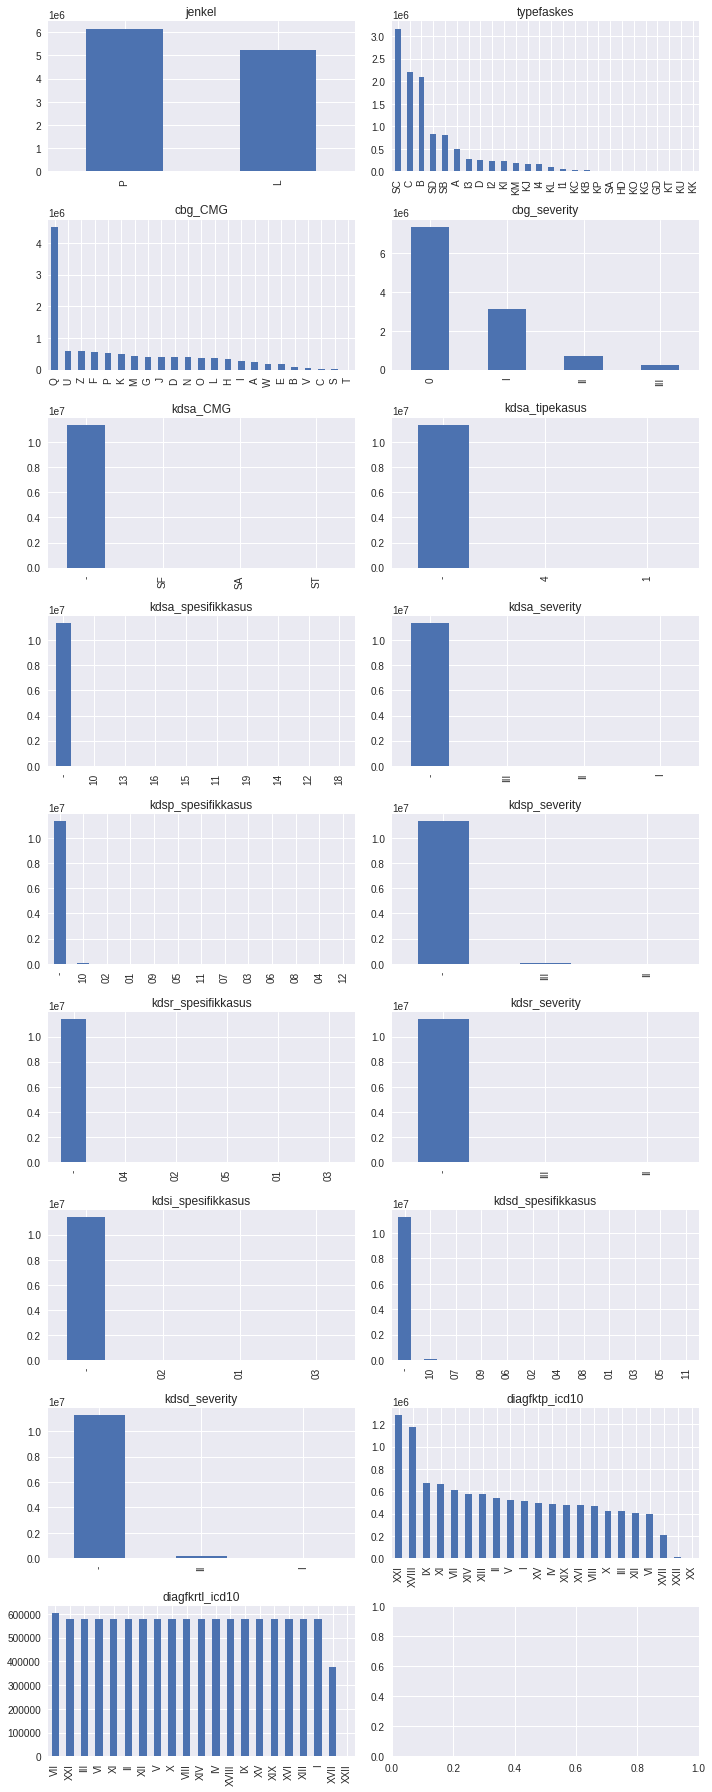

In [ ]:
plt.style.use("seaborn")
fig, ax = plt.subplots(9, 2, figsize=(10,25))

for i ,ax in zip(range(len(cat_col)), ax.flat):
  if i==17:
    break
  else:
    df_no_dup_prepared[cat_col[i]].value_counts().plot(kind="bar" , ax=ax)
    ax.set_title(cat_col[i])

plt.tight_layout()
plt.show()

Insight dari visualisasi di atas:
1. Untuk fitur 'jenkel':
   komposisi perbandingan jumlah jenis kelamin, perempuan lebih banyak dari laki-laki.

2. Untuk fitur 'typefaskes':
   3 tipe teratas fasilitas kesehatan yang sering digunakan, yaitu SC, C, B.
3. Untuk fitur 'cbg_CMG':
   Kode yang memiliki jumlah terbanyak pada dataset, yaitu Q (Ambulatory Groups-Episodic).
4. Untuk fitur 'cbg_severity':
   urutan jumlah dari yang terbanyak itu adalah 0, I, II, dan III.
5. Untuk fitur yang berkaitan dengan 'kdsa' dan 'kdsp':
   data untuk nilai terbanyak berasal dari (-) atau kosong.
6. Untuk fitur 'diagfktp_icd10':
   Data terbanyak, yaitu untuk kode XXI dan XVIII, untuk yang lainnya tidak jauh berbeda.
7. Untuk fitur 'diagfkrtl_icd10':
   Untuk setiap kode memiliki jumlah yang banyak, tetapi yang terbanyak adalah untuk kode VII.

In [ ]:
df_no_dup_prepared.typefaskes.value_counts()

SC    3165557
C     2197422
B     2102706
SD     825689
SB     808443
A      493053
I3     285778
D      260327
I2     226470
KI     221111
KM     177017
KJ     173692
I4     164106
KL     101933
I1      49979
KC      28917
KB      25479
KP      17850
SA      17174
HD      14390
KO      12804
KG      11134
GD       9273
KT       7375
KU       4180
KK          9
Name: typefaskes, dtype: int64

In [ ]:
typefaskes_name = df_no_dup_prepared.typefaskes.value_counts().index
typefaskes_val = df_no_dup_prepared.typefaskes.value_counts().values

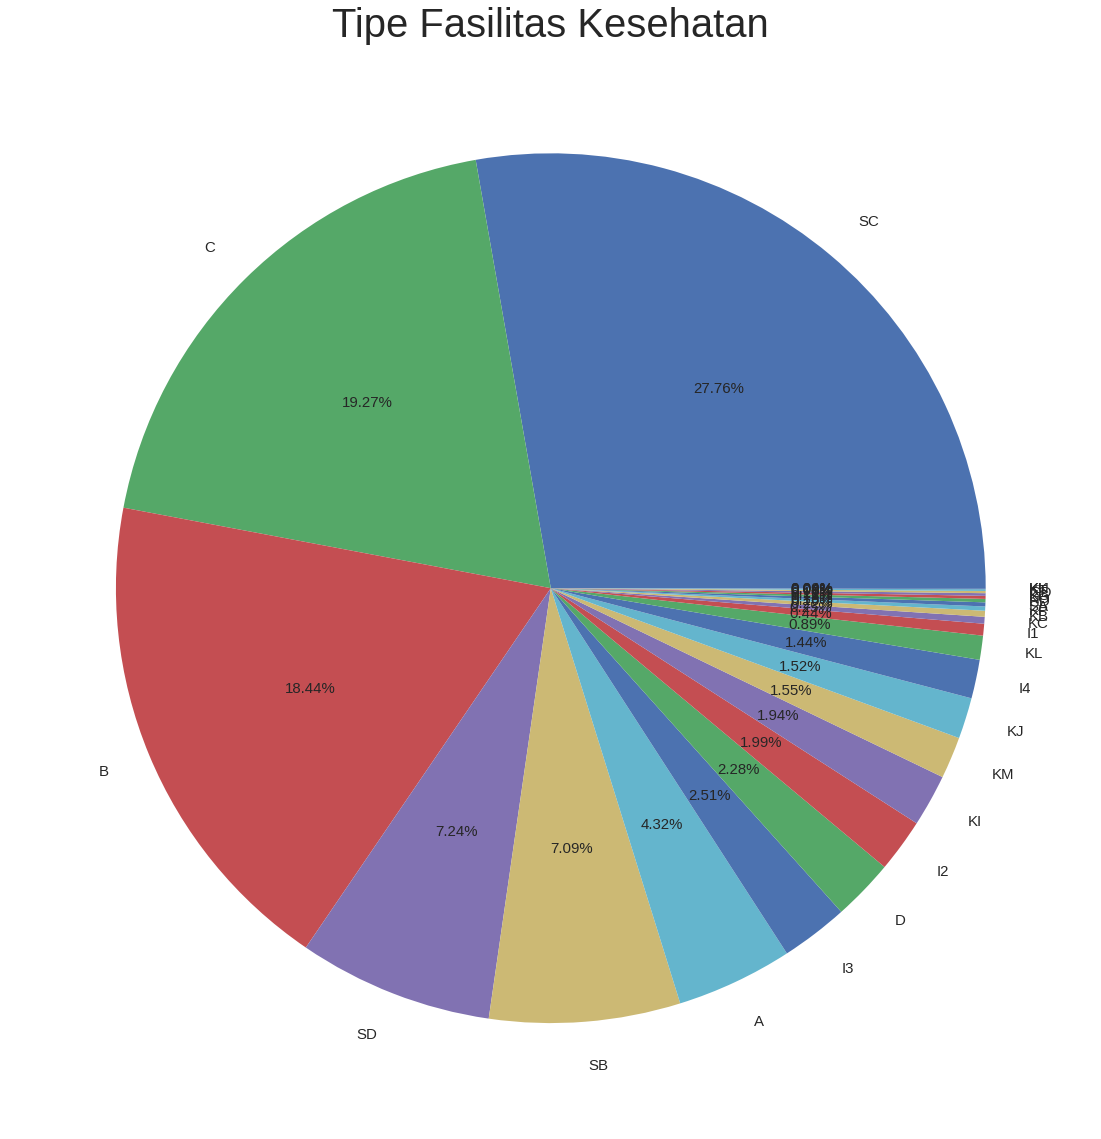

In [ ]:
plt.subplots(figsize=(20,20))
plt.pie(typefaskes_val, labels=typefaskes_name, autopct='%1.2f%%', textprops={"fontsize":15})
plt.title('Tipe Fasilitas Kesehatan', fontsize=40)
plt.show()

Ini adalah perbandingan banyaknya tipe fasilitas kesehatan yang digunakan.
1. Tipe SC memiliki komposisi tertinggi dengan nilai 27.76% dari total keseluruhan atau sama dengan 3165557.
2. Tipe C memiliki komposisi tertinggi kedua dengan nilai 19.27% dari total keseluruhan atau sama dengan 2197422.
3. Tipe B memiliki komposisi tertinggi ketiga dengan nilai 18.44% dari total keseluruhan atau sama dengan 2102706.
4. Dan untuk sisanya setiap tipe memilki jumlah kurang 1 juta atau dibawah 10%.

In [ ]:
jenkel_kind = df_no_dup_prepared.jenkel.value_counts().index
jenkel_val = df_no_dup_prepared.jenkel.value_counts().values

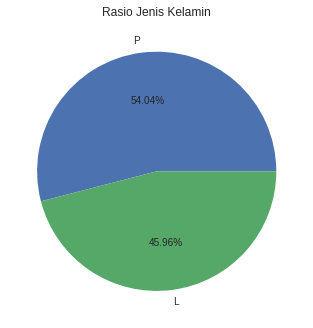

In [ ]:
plt.pie(jenkel_val, labels=jenkel_kind, autopct='%1.2f%%')
plt.title('Rasio Jenis Kelamin')
plt.show()

Pie chart untuk melihat rasio dari jumlah jenis kelamin.
Jenis kelamin perempuan memiliki rasio yang lebih tinggi, yaitu 54.04%. Dibandingkan dengan jenis kelamin laki-laki yang hanya 46.96%.


##Exploratory Data Numerical

In [ ]:
df_no_dup_prepared.describe()

,jenispulang,pisat,biaya,id,id_peserta,usia,jenispel,kelasrawat,label,lama_rawat,cbg_tipekasus,cbg_spesifikkasus,diagfkrtl_sekunder_counts
count,1.140187e+07,1.140187e+07,1.140187e+07,1.140187e+07,1.140187e+07,1.140187e+07,1.140187e+07,1.140187e+07,1.140187e+07,1.140187e+07,1.140187e+07,1.140187e+07,1.140187e+07
mean,1.094596e+00,2.498179e+00,2.137413e+06,5.712718e+06,4.199294e+06,3.705690e+01,1.645544e+00,2.784696e+00,1.375950e-02,1.524959e+00,4.318791e+00,2.659615e+01,5.169803e-01
std,5.131545e-01,1.390865e+00,5.196030e+06,3.298534e+06,2.436249e+06,2.292188e+01,4.783481e-01,5.511468e-01,1.164911e-01,5.294593e+00,1.439825e+00,1.439364e+01,9.179885e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,1.904000e+05,2.855429e+06,2.119460e+06,1.800000e+01,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.300000e+01,0.000000e+00
50%,1.000000e+00,3.000000e+00,2.872000e+05,5.712226e+06,4.161532e+06,3.900000e+01,2.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,2.000000e+01,0.000000e+00
75%,1.000000e+00,4.000000e+00,2.982100e+06,8.568898e+06,6.292148e+06,5.600000e+01,2.000000e+00,3.000000e+00,0.000000e+00,2.000000e+00,5.000000e+00,4.300000e+01,1.000000e+00
max,5.000000e+00,5.000000e+00,4.016966e+08,1.142696e+07,8.527919e+06,1.100000e+02,2.000000e+00,3.000000e+00,1.000000e+00,1.431000e+03,9.000000e+00,8.400000e+01,3.100000e+01


Diperlihatkan statistik deskriptif untuk setiap fitur yang memiliki jenis data numerik. Terdapat:
count(banyak data), mean(rata-rata nilai per fitur), std(standart deviasi/
persebaran rata-rata dari tiap fitur),

*   count(banyak data)
*   mean(rata-rata nilai per fitur)
*   std(standart deviasi/persebaran rata-rata dari tiap fitur)
*   min(nilai minimum data di setiap fitur)
*   25%(Nilai pada kuartil ke-1 di setiap fitur)
*   50%(Nilai pada kuartil ke-1 di setiap fitur)
*   75%(Nilai pada kuartil ke-1 di setiap fitur)
*   max(nilai maksimum data di setiap fitur)







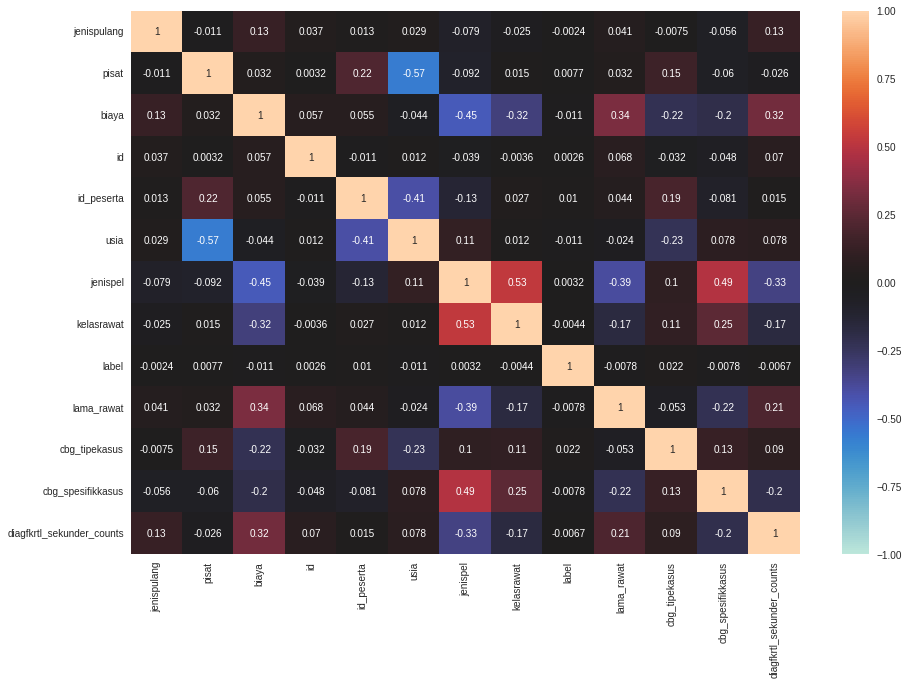

In [ ]:
plt.subplots(figsize=(15,10))
sns.heatmap(df_no_dup_prepared.select_dtypes(exclude='O').corr(), vmin = -1, vmax = 1, center = 0, annot=True)
plt.show()

Heatmap untuk memvisualisasikan koefisien korelasi dari setiap fitur.
Terdapat beberapa fitur yang memiliki koefisien korelasi yang cukuk kuat, baik itu positif ataupun negatif, diantaranya:
1. fitur 'biaya' dengan 'jenispel' atau jenis pelayanan, yaitu -0.45.
2. fitur 'biaya' dengan 'kelasrawat', yaitu -0.32.
3. fitur 'biaya' dengan 'lama_rawat' atau durasi hari yang dihabiskan oleh pasien untuk rawat inap di rumah sakit, yaitu 0.34.
4. fitur 'biaya' dengan 'cbg_tipekasus' atau Group Tipe Kasus dalam INA-CBGs, yaitu -0.22.
5. fitur 'biaya' dengan 'cbg_spesifikkasus' atau spesifik CBGs yang dilambangkan dengan numerik mulai dari 01 sampai dengan 99, yaitu -0.2.
6. fitur 'biaya' dengan 'diagfkrtl_sekunder_counts' atau Frekuensi yg level diagnosanya sekunder dari tiap id, yaitu 0.32.
7. fitur 'usia' dengan 'pisat', yaitu -0.57.
8. fitur 'usia' dengan 'id_peserta', yaitu -0.41.
9. fitur 'jenispel' dengan 'kelasrawat', yaitu 0.53.
10. fitur 'jenispel' dengan 'lama_rawat', yaitu -0.39. \
dll. dengan ketentuan semakin menuju 0, maka semakin tidak ada korelasinya diantara fitur yang dihubungkan.

In [ ]:
group1 = df_no_dup_prepared.groupby(['biaya', 'jenispel', 'kelasrawat', 'lama_rawat', 'cbg_tipekasus', 'cbg_spesifikkasus', 'diagfkrtl_sekunder_counts']).size().reset_index()
group1.rename(columns={0:'count'}, inplace= True)
group1

,biaya,jenispel,kelasrawat,lama_rawat,cbg_tipekasus,cbg_spesifikkasus,diagfkrtl_sekunder_counts,count
0,0.0,1,1,0,4,10,0.0,1
1,0.0,1,1,0,4,10,4.0,1
2,0.0,1,1,0,4,11,0.0,3
3,0.0,1,1,0,4,12,0.0,1
4,0.0,1,1,0,4,13,0.0,9
...,...,...,...,...,...,...,...,...
616366,396933400.0,1,1,18,1,1,0.0,1
616367,396933400.0,1,1,28,1,1,1.0,1
616368,400505800.0,1,1,13,1,1,1.0,1
616369,400505800.0,1,1,29,1,1,3.0,1


In [ ]:
df_no_dup_prepared.loc[:,['biaya', 'jenispel', 'kelasrawat', 'lama_rawat', 'cbg_tipekasus', 'cbg_spesifikkasus', 'diagfkrtl_sekunder_counts']].groupby(['diagfkrtl_sekunder_counts']).max()

,biaya,jenispel,kelasrawat,lama_rawat,cbg_tipekasus,cbg_spesifikkasus
diagfkrtl_sekunder_counts,,,,,,
0.0,401696600.0,2,3,1431,9,84
1.0,400505800.0,2,3,789,9,84
2.0,396933400.0,2,3,579,9,84
3.0,400505800.0,2,3,488,9,83
4.0,353570300.0,2,3,511,9,80
5.0,312535300.0,2,3,299,9,80
6.0,309451300.0,2,3,525,9,80
7.0,309451300.0,2,3,153,8,80
8.0,353570300.0,2,3,270,8,80


In [ ]:
pivot1 = pd.pivot_table(data=df_no_dup_prepared.loc[:,['biaya','lama_rawat','cbg_tipekasus']], index='cbg_tipekasus', aggfunc= np.max)
pivot2 = pd.pivot_table(data=df_no_dup_prepared.loc[:,['biaya','lama_rawat','cbg_tipekasus']], index='cbg_tipekasus', aggfunc= np.min)
pivot3 = pd.pivot_table(data=df_no_dup_prepared.loc[:,['biaya','lama_rawat','cbg_tipekasus']], index='cbg_tipekasus', aggfunc= np.mean)
pivot1.sort_values(by='biaya', ascending=False)

,biaya,lama_rawat
cbg_tipekasus,,
1,401696600.0,729
8,353570300.0,511
4,87974100.0,1431
6,15103200.0,373
5,10844400.0,69
2,9261000.0,0
3,7885800.0,54
7,1997600.0,0
9,809500.0,0


In [ ]:
pivot2

,biaya,lama_rawat
cbg_tipekasus,,
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,287200.0,0
8,0.0,0
9,0.0,0


In [ ]:
pivot3.sort_values(by='biaya', ascending=False)

,biaya,lama_rawat
cbg_tipekasus,,
1,1.089181e+07,3.782153
8,5.092631e+06,3.836663
6,4.071990e+06,2.313267
2,3.881777e+06,0.000000
4,3.728360e+06,4.866109
7,8.004990e+05,0.000000
3,4.033693e+05,0.000051
5,3.462454e+05,0.000073
9,2.967929e+05,0.000000


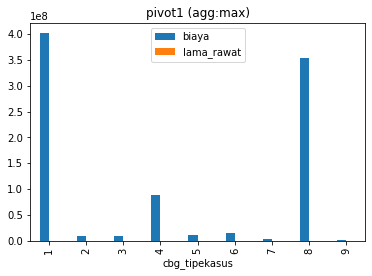

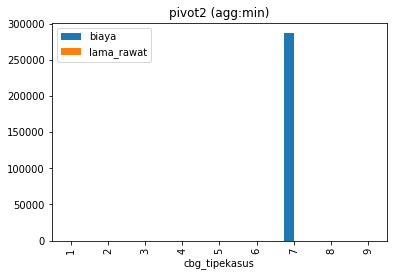

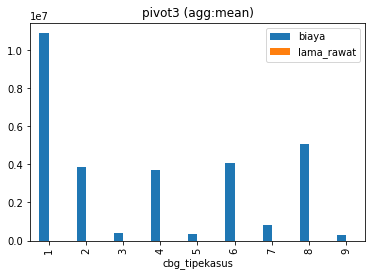

In [ ]:
pivot1.plot(kind='bar')
plt.title('pivot1 (agg:max)')

pivot2.plot(kind='bar')
plt.title('pivot2 (agg:min)')

pivot3.plot(kind='bar')
plt.title('pivot3 (agg:mean)')

plt.show()

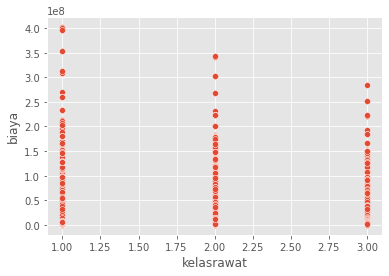

In [ ]:
sns.scatterplot(data=df_no_dup_prepared, x='kelasrawat', y='biaya')
plt.show()

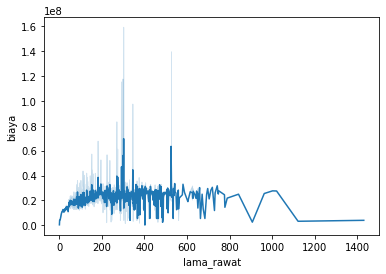

In [ ]:
sns.lineplot(data=df_no_dup_prepared, x='lama_rawat', y='biaya')
plt.show()

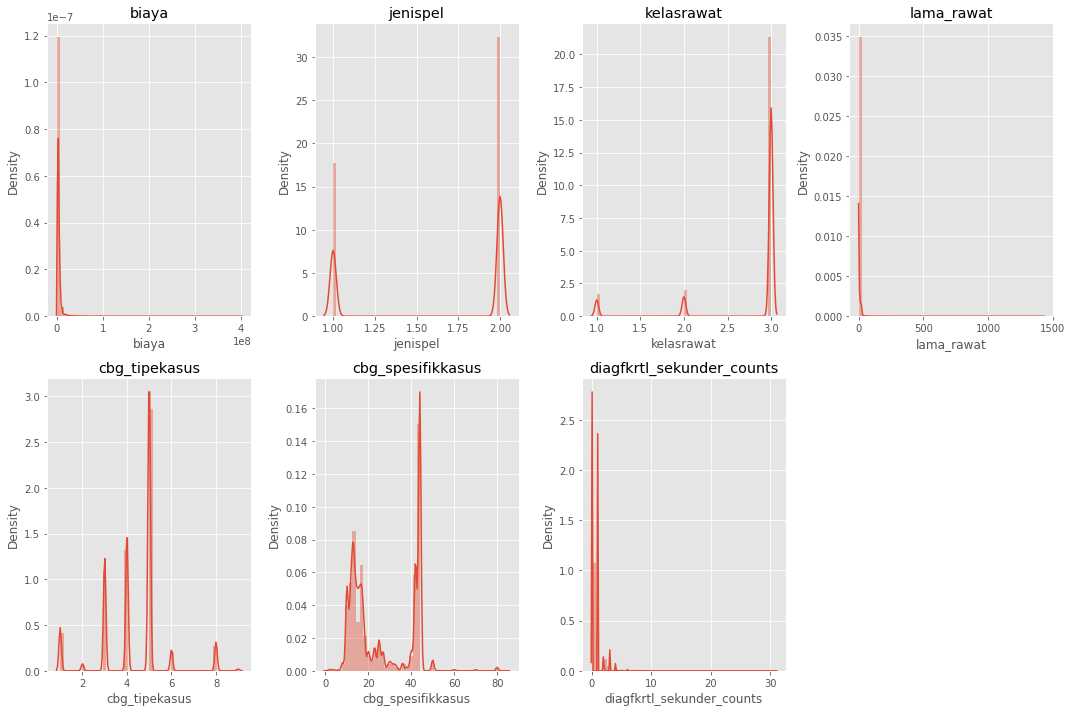

In [ ]:
# Plot histogram untuk masing - masing fitur
plt.style.use("ggplot")
fig, ax = plt.subplots(2, 4, figsize=(15,10))
col = ['biaya', 'jenispel', 'kelasrawat', 'lama_rawat', 'cbg_tipekasus', 'cbg_spesifikkasus', 'diagfkrtl_sekunder_counts']
ax[-1,-1].axis('off')
for i, ax in zip(range(len(col)), ax.flat):
  sns.distplot(df_no_dup_prepared[col[i]], kde=True, ax=ax)
  ax.set_title(col[i])

plt.tight_layout()
plt.show()

## Preprocessing

In [ ]:
X = df_no_dup_prepared.drop(['id', 'id_peserta', 'label'], axis=1)
y = df_no_dup_prepared.label.values

In [ ]:
CMG_categories = ['-', 'G', 'H', 'U', 'J', 'I', 'K', 'B', 'M', 'L', 'E', 'N', 'V', 
                 'W', 'O', 'P', 'D', 'C', 'A', 'F', 'T', 'S', 'Z', 'Q', 'QP',
                 'SA', 'ST', 'SF', 'YY', 'DD', 'II', 'IJ', 'RR', 'CD', 'X']
tipekasus_categories = [str(x) for x in range(0,10)]
tipekasus_categories.insert(0, '-')
spesifikkasus_categories = [str(x) for x in range(1,100)]
spesifikkasus_categories.insert(0, '-')
severity_categories = ['-', '0', 'I', 'II', 'III']
icd10_categories = ['I', 'II', 'III', 'IV', 'IX', 'V', 'VI', 'VII', 'VIII', 
                    'X', 'XI', 'XII', 'XIII', 'XIV', 'XIX', 'XV', 'XVI', 
                    'XVII', 'XVIII', 'XX', 'XXI', 'XXII']

Cell dibawah merupakan one hot encoder untuk kolom yang sudah diketahui kategori-kategorinya

In [ ]:
onehot_known_enc = OneHotEncoder(categories=[CMG_categories, tipekasus_categories, spesifikkasus_categories,
                                             CMG_categories, tipekasus_categories, spesifikkasus_categories,
                                             spesifikkasus_categories, spesifikkasus_categories,
                                             spesifikkasus_categories, spesifikkasus_categories, icd10_categories,
                                             icd10_categories], handle_unknown='ignore')

known_cat_col = ['cbg_CMG', 'cbg_tipekasus', 'cbg_spesifikkasus',
                 'kdsa_CMG', 'kdsa_tipekasus', 'kdsa_spesifikkasus',
                 'kdsp_spesifikkasus', 'kdsr_spesifikkasus',
                 'kdsi_spesifikkasus', 'kdsd_spesifikkasus',
                 'diagfktp_icd10', 'diagfkrtl_icd10', 'typefaskes']

Cell dibawah merupakan one hot encoder untuk cell yang tidak diketahui banyak kategorinya

In [ ]:
onehot_unk_enc = OneHotEncoder()
unknown_cat_col = ['typefaskes']

Cell dibawah merupakan ordinal encoder, yang kami gunakan untuk kolom bernilai biner atau kolom kategorik yang memiliki "tingkatan"

In [ ]:
ordinal_enc = OrdinalEncoder(categories=[['L', 'P'], severity_categories, severity_categories, 
                                         severity_categories, severity_categories, severity_categories])
ordinal_col = ['jenkel', 'cbg_severity', 'kdsa_severity', 
               'kdsp_severity', 'kdsr_severity', 'kdsd_severity']

In [ ]:
preprocess = ColumnTransformer([
    ('onehot1', onehot_known_enc, known_cat_col),
    ('onehot2', onehot_unk_enc, unknown_cat_col),
    ('ordinal_enc', ordinal_enc, ordinal_col)
], remainder='passthrough')

In [ ]:
preprocess.fit(X)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot1',
                                 OneHotEncoder(categories=[['-', 'G', 'H', 'U',
                                                            'J', 'I', 'K', 'B',
                                                            'M', 'L', 'E', 'N',
                                                            'V', 'W', 'O', 'P',
                                                            'D', 'C', 'A', 'F',
                                                            'T', 'S', 'Z', 'Q',
                                                            'QP', 'SA', 'ST',
                                                            'SF', 'YY', 'DD', ...],
                                                           ['-', '0', '1', '2',
                                                            '3', '4', '5', '6',
                                                            '7', '8', '9'],
                                                           ['-', '1', '2', '3',
                                                            '4', '5', '6', '7',
                                                            '8', '9', '10',
                                                            '11', '12', '13',
                                                            '14', '15', '16',
                                                            '17...
                                  'diagfktp_icd10', 'diagfkrtl_icd10']),
                                ('onehot2', OneHotEncoder(), ['typefaskes']),
                                ('ordinal_enc',
                                 OrdinalEncoder(categories=[['L', 'P'],
                                                            ['-', '0', 'I',
                                                             'II', 'III'],
                                                            ['-', '0', 'I',
                                                             'II', 'III'],
                                                            ['-', '0', 'I',
                                                             'II', 'III'],
                                                            ['-', '0', 'I',
                                                             'II', 'III'],
                                                            ['-', '0', 'I',
                                                             'II', 'III']]),
                                 ['jenkel', 'cbg_severity', 'kdsa_severity',
                                  'kdsp_severity', 'kdsr_severity',
                                  'kdsd_severity'])])

In [ ]:
X_prepared = preprocess.transform(X)

In [ ]:
X_prepared.shape

(11401868, 777)

# Modelling XGBoost

XGBoost ini nantinya akan dibandingkan dengan Light GBM pada section selanjutnya

## Hyperparameter Tuning

Hyperparameter tuning dilakukan dengan metode Bayesian search optimization.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=.75)
X_train.shape, y_train.shape

((2850467, 776), (2850467,))

Model di-wrap dalam bentuk pipeline, agar input training secara langsung dapat dilakukan resample

In [ ]:
model_pipeline = imbpipeline([
    ('over', SMOTE(sampling_strategy=.15)),
    ('under', RandomUnderSampler(sampling_strategy=.5)),
    ('xgb', xgb.XGBClassifier(n_estimators=50, objective='binary:logistic', tree_method='approx', 
                              verbosity=2, n_jobs=-1))
])

In [ ]:
params = {'over__sampling_strategy': Real(.1, .6, 'log-uniform'),
          'over__k_neighbors': Integer(5, 1000),
         'under__sampling_strategy': Real(.6, .9, 'log-uniform'),
         'xgb__learning_rate': Real(1e-2, 1),
         'xgb__max_depth': Integer(6, 64),
         'xgb__subsample': Real(0.5, 1),
         'xgb__colsample_bytree': Real(0.5, 1),
         'xgb__reg_alpha': Real(1e-2, 10, 'log-uniform'),
         'xgb__reg_lambda': Real(1e-2, 10, 'log-uniform'),
         'xgb__gamma': Real(0, 5),
         'xgb__min_child_weight': Integer(1, 10)}

search = BayesSearchCV(model_pipeline, params, scoring='roc_auc', cv=3, 
                       verbose=10, n_jobs=-1, n_iter=100,
                       return_train_score=True)

In [ ]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

[22:22:10] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[22:22:17] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[22:22:22] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[22:22:28] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[22:22:33] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[22:22:37] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[22:22:42] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[22:22:47] IN

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('over', SMOTE(sampling_strategy=0.15)),
                                        ('under',
                                         RandomUnderSampler(sampling_strategy=0.5)),
                                        ('xgb',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       gamma=None, gp...
                             'xgb__max_depth': Integer(low=6, high=64, prior='uniform', transform='normalize'),
                             'xgb__min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'xgb__reg_alpha': Real(low=0.01, high=10, prior='log-uniform', transform='normalize'),
                             'xgb__reg_lambda': Real(low=0.01, high=10, prior='log-uniform', transform='normalize'),
                             'xgb__subsample': Real(low=0.5, high=1, prior='uniform', transform='normalize')},
              verbose=10)

Diperoleh parameter yang menghasilkan AUC-score terbaik adalah sebagai berikut.

In [ ]:
search.best_params_, search.best_score_

(OrderedDict([('over__k_neighbors', 858),
              ('over__sampling_strategy', 0.19676221847208702),
              ('under__sampling_strategy', 0.8849275028627146),
              ('xgb__colsample_bytree', 0.5),
              ('xgb__gamma', 0.0),
              ('xgb__learning_rate', 0.15377367769556463),
              ('xgb__max_depth', 64),
              ('xgb__min_child_weight', 1),
              ('xgb__reg_alpha', 1.8796306666826916),
              ('xgb__reg_lambda', 0.01),
              ('xgb__subsample', 1.0)]),
 0.8761330699524369)

## Train tuned hyperparameter

Dengan menggunakan hyperparameter terbaik yang sudah diperoleh, dilakukan training model dengan data train sebanyak 32% dari data keseluruhan. Pada training kami menggunakan early stopping.

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_prepared, y, 
                                                              test_size=.6, 
                                                              random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, 
                                                  y_train_full, 
                                                  test_size=.2, 
                                                  random_state=42)

X_train.shape, X_val.shape, X_test.shape

((3648597, 777), (912150, 777), (6841121, 777))

In [ ]:
es = xgb.callback.EarlyStopping(rounds=100, metric_name='auc', 
                                data_name='validation_0', 
                                maximize=True,
                                save_best=True)

model_pipeline = imbpipeline([
    ('over', SMOTE(sampling_strategy=0.19676221847208702, n_jobs=-1, 
                   k_neighbors=858)),
    ('under', RandomUnderSampler(sampling_strategy=0.8849275028627146)),
    ('xgb', xgb.XGBClassifier(n_estimators=1000, colsample_bytree=0.5, 
                              gamma=0, learning_rate=0.05377367769556463, 
                              max_depth=64, reg_alpha=1.8796306666826916, 
                              reg_lambda=0.01, subsample=1.0, 
                              min_child_weight=1, 
                              scale_pos_weight=1/0.8849275028627146,
                              callbacks=[es], objective='binary:logistic', 
                              eval_metric=['auc', 'logloss'],
                              verbosity=2, n_jobs=-1, tree_method='approx'))
])

In [ ]:
model_pipeline.fit(X_train, y_train, xgb__eval_set=[(X_val, y_val)])

[22:54:32] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[0]	validation_0-auc:0.67683	validation_0-logloss:0.64952
[22:54:39] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[1]	validation_0-auc:0.70604	validation_0-logloss:0.60979
[22:54:44] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[2]	validation_0-auc:0.84296	validation_0-logloss:0.57108
[22:54:53] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[3]	validation_0-auc:0.83671	validation_0-logloss:0.53939
[22:55:00] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[4]	validation_0-auc:0.84725	validation_0-logloss:0.50681
[22:5

[41]	validation_0-auc:0.87461	validation_0-logloss:0.11814
[22:59:45] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[42]	validation_0-auc:0.87490	validation_0-logloss:0.11574
[22:59:52] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[43]	validation_0-auc:0.87521	validation_0-logloss:0.11295
[23:00:02] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[44]	validation_0-auc:0.87606	validation_0-logloss:0.11014
[23:00:12] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[45]	validation_0-auc:0.87642	validation_0-logloss:0.10761
[23:00:19] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.


[82]	validation_0-auc:0.88386	validation_0-logloss:0.06919
[23:05:17] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[83]	validation_0-auc:0.88410	validation_0-logloss:0.06873
[23:05:25] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[84]	validation_0-auc:0.88412	validation_0-logloss:0.06845
[23:05:31] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[85]	validation_0-auc:0.88435	validation_0-logloss:0.06802
[23:05:37] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[86]	validation_0-auc:0.88455	validation_0-logloss:0.06762
[23:05:43] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.


[123]	validation_0-auc:0.88635	validation_0-logloss:0.06093
[23:09:21] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[124]	validation_0-auc:0.88642	validation_0-logloss:0.06082
[23:09:25] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[125]	validation_0-auc:0.88635	validation_0-logloss:0.06075
[23:09:31] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[126]	validation_0-auc:0.88643	validation_0-logloss:0.06065
[23:09:35] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[127]	validation_0-auc:0.88645	validation_0-logloss:0.06059
[23:09:40] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient In

[164]	validation_0-auc:0.88618	validation_0-logloss:0.05859
[23:12:35] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[165]	validation_0-auc:0.88617	validation_0-logloss:0.05856
[23:12:40] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[166]	validation_0-auc:0.88601	validation_0-logloss:0.05853
[23:12:45] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[167]	validation_0-auc:0.88599	validation_0-logloss:0.05851
[23:12:49] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[168]	validation_0-auc:0.88594	validation_0-logloss:0.05848
[23:12:55] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient In

[205]	validation_0-auc:0.88416	validation_0-logloss:0.05763
[23:15:40] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[206]	validation_0-auc:0.88417	validation_0-logloss:0.05762
[23:15:44] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[207]	validation_0-auc:0.88410	validation_0-logloss:0.05760
[23:15:49] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[208]	validation_0-auc:0.88414	validation_0-logloss:0.05758
[23:15:53] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[209]	validation_0-auc:0.88402	validation_0-logloss:0.05756
[23:15:57] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient In

Pipeline(steps=[('over',
                 SMOTE(k_neighbors=858, n_jobs=-1,
                       sampling_strategy=0.19676221847208702)),
                ('under',
                 RandomUnderSampler(sampling_strategy=0.8849275028627146)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               callbacks=[<xgboost.callback.EarlyStopping object at 0x0000011BDE08CC10>],
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.5, ear...
                               gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.05377367769556463, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=64, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=1000, n_jobs=-1,
                               num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=1.8796306666826916,
                               reg_lambda=0.01, ...))])

In [ ]:
model_pipeline.named_steps.xgb.best_iteration

143

In [ ]:
y_val_pred = model_pipeline.predict(X_val)

print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    899559
           1       0.66      0.46      0.54     12591

    accuracy                           0.99    912150
   macro avg       0.83      0.73      0.77    912150
weighted avg       0.99      0.99      0.99    912150



## Tune model threshold

Tuning threshold berfungsi agar kami dapat memperoleh precision/recall yang diinginkan, karena adanya precision-recall trade-off

In [ ]:
y_val_pred_proba = model_pipeline.predict_proba(X_val)
y_val_pred_proba

array([[0.9856673 , 0.01433268],
       [0.98014903, 0.01985099],
       [0.98094934, 0.01905065],
       ...,
       [0.994895  , 0.00510501],
       [0.9835669 , 0.01643315],
       [0.705318  , 0.29468203]], dtype=float32)

In [ ]:
y_val_pred_proba = y_val_pred_proba[:, 1]

In [ ]:
roc_auc_score(y_val, y_val_pred_proba)

0.8868023879870464

Cell dibawah adalah plot dari ROC curve. Pada plot ROC Curve ini, kami tidak dapat menyimpulkan precision-recall trade-off yang dapat diperoleh pada model.

In [ ]:
fpr, tpr, th_roc = roc_curve(y_val, y_val_pred_proba)

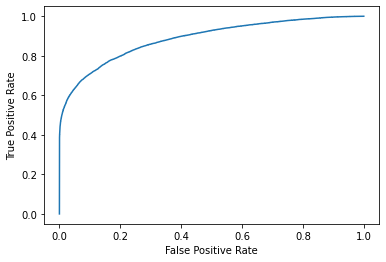

In [ ]:
plot_roc = RocCurveDisplay(fpr=fpr, tpr=tpr)
plot_roc.plot()

Selanjutnya, kami plot Precision-Recall Curve

In [ ]:
precision, recall, th_pr = precision_recall_curve(y_val, y_val_pred_proba)

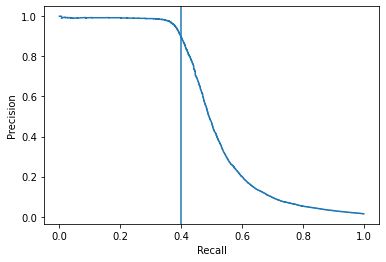

In [ ]:
plot_pr = PrecisionRecallDisplay(precision=precision, recall=recall)
plot_pr.plot()
plt.axvline(x=recall[np.argmax(recall <= 0.4)])
plt.show()

Terlihat pada plot di atas, precision terlihat menurun drastis ketika recall mencapai sekitar 0.4. Pada kasus ini, karena apabila recall tinggi, diperoleh precision yang sangat rendah, maka kami memutuskan untuk mengambil precision setidaknya 0.9.

Pada cell dibawah, kami ingin mencari berapa threshold yang menghasilkan precision setidaknya 0.9. Diperoleh precision yang cukup tinggi pada validation set dan f1-score yang baik. Sehingga akan digunakan model ini

In [ ]:
th_prec_09 = th_pr[np.argmax(precision > 0.9)]

print(classification_report(y_val, (y_val_pred_proba >= th_prec_09).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    899559
           1       0.90      0.40      0.55     12591

    accuracy                           0.99    912150
   macro avg       0.95      0.70      0.77    912150
weighted avg       0.99      0.99      0.99    912150



In [ ]:
accuracy_score(y_val, (y_val_pred_proba >= th_prec_09).astype(int))

0.9910847996491805

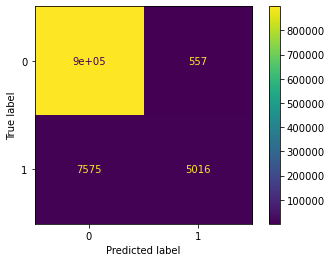

In [ ]:
cm3 = confusion_matrix(y_val, (y_val_pred_proba >= th_prec_09).astype(int), labels=model_pipeline.named_steps.xgb.classes_)
disp = ConfusionMatrixDisplay(cm3, display_labels=model_pipeline.named_steps.xgb.classes_)
disp.plot()
plt.show()

In [ ]:
cm3[0,0]/(cm3[0,0]+cm3[0,1])

0.9993808077068875

Cell dibawah berfungsi untuk membuat class estimator yang bisa memprediksi suatu data menggunakan threshold yang sudah ditentukan.

In [ ]:
class XGB_custom_th(BaseEstimator):
    def __init__(self, th=th_prec_09):
        self.th = th
        self.model = model_pipeline
    def fit(self):
        return self
    def predict(self, X):
        y_pred = self.model.predict_proba(X)[:, 1]
        return (y_pred >= self.th).astype(int)

In [ ]:
final_model = XGB_custom_th()
y_val_pred = final_model.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    899559
           1       0.90      0.40      0.55     12591

    accuracy                           0.99    912150
   macro avg       0.95      0.70      0.77    912150
weighted avg       0.99      0.99      0.99    912150



## Evaluation on Test Set dengan model XGBoost

Evaluasi data pada test set menunjukkan hasil yang mirip dengan validation set. Ini menunjukkan bahwa model kami dapat menggeneralisasi data dengan baik.

In [ ]:
start = time.time()
y_test_pred = final_model.predict(X_test)
stop = time.time()
print('XGBoost Predict time on test set: {} seconds'.format(stop - start))
print(classification_report(y_test, y_test_pred))

XGBoost Predict time on test set: 592.9001433849335 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   6747001
           1       0.91      0.40      0.56     94120

    accuracy                           0.99   6841121
   macro avg       0.95      0.70      0.78   6841121
weighted avg       0.99      0.99      0.99   6841121



# Modelling Light GBM

Selanjutnya, dilakukan langkah yang sama seperti XGBoost untuk tuning hyperparameter Light GBM. Lalu, dibandingkan hasil akhirnya pada test set yang sama.

## Hyperparameter Tuning

Hyperparameter tuning dilakukan dengan metode Bayesian search optimization.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=.75)
X_train.shape, y_train.shape

((2850467, 776), (2850467,))

Model di-wrap dalam bentuk pipeline, agar input training secara langsung dapat dilakukan resample

In [ ]:
model_pipeline = imbpipeline([
    ('over', SMOTE(sampling_strategy=.15)),
    ('under', RandomUnderSampler(sampling_strategy=.5)),
    ('lgbm', lgbm.LGBMClassifier(n_estimators=100, objective='binary', 
                                 verbosity=1, n_jobs=-1))
])

In [ ]:
params = {'over__sampling_strategy': Real(.1, .6, 'log-uniform'),
          'over__k_neighbors': Integer(5, 1000),
          'under__sampling_strategy': Real(.6, .9, 'log-uniform'),
          'lgbm__boosting_type': Categorical(['gbdt', 'dart', 'goss']),
          'lgbm__learning_rate': Real(1e-2, 1),
          'lgbm__max_depth': Integer(3, 32),
          'lgbm__colsample_bytree': Real(0.5, 1),
          'lgbm__reg_alpha': Real(1e-2, 10, 'log-uniform'),
          'lgbm__reg_lambda': Real(1e-2, 10, 'log-uniform'),
          'lgbm__min_split_gain': Real(0, 5),
          'lgbm__num_leaves': Integer(10, 10000),
          'lgbm__min_child_samples': Integer(200, 2000)}

search = BayesSearchCV(model_pipeline, params, scoring='roc_auc', cv=3, 
                       verbose=10, n_jobs=-1, n_iter=200, 
                       return_train_score=True)

In [ ]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('over', SMOTE(sampling_strategy=0.15)),
                                        ('under',
                                         RandomUnderSampler(sampling_strategy=0.5)),
                                        ('lgbm',
                                         LGBMClassifier(objective='binary',
                                                        verbosity=1))]),
              n_iter=200, n_jobs=-1, return_train_score=True, scoring='roc_auc',
              search_spaces={'lgbm__boosting_type': Categorical(categories=('gbdt', 'dart', 'goss'), prior=None...
                             'lgbm__reg_lambda': Real(low=0.01, high=10, prior='log-uniform', transform='normalize'),
                             'over__k_neighbors': Integer(low=5, high=1000, prior='uniform', transform='normalize'),
                             'over__sampling_strategy': Real(low=0.1, high=0.6, prior='log-uniform', transform='normalize'),
                             'under__sampling_strategy': Real(low=0.6, high=0.9, prior='log-uniform', transform='normalize')},
              verbose=10)

Diperoleh parameter yang menghasilkan AUC-score terbaik adalah sebagai berikut.

In [ ]:
search.best_params_, search.best_score_

(OrderedDict([('lgbm__boosting_type', 'dart'),
              ('lgbm__colsample_bytree', 0.5510238606246517),
              ('lgbm__learning_rate', 0.13366708157335833),
              ('lgbm__max_depth', 25),
              ('lgbm__min_child_samples', 200),
              ('lgbm__min_split_gain', 0.12624055231690842),
              ('lgbm__num_leaves', 3213),
              ('lgbm__reg_alpha', 0.01),
              ('lgbm__reg_lambda', 0.01),
              ('over__k_neighbors', 1000),
              ('over__sampling_strategy', 0.10107109574278936),
              ('under__sampling_strategy', 0.6967907665329958)]),
 0.8788098860324153)

## Train tuned hyperparameter

Dengan menggunakan hyperparameter terbaik yang sudah diperoleh, dilakukan training model dengan data train sebanyak 32% dari data keseluruhan (data train, validasi, dan test sama seperti ketika train XGBoost, karena menggunakan random_state). Pada training kami menggunakan early stopping.

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_prepared, y, 
                                                              test_size=.6, 
                                                              random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, 
                                                  y_train_full, 
                                                  test_size=.2, 
                                                  random_state=42)

X_train.shape, X_val.shape, X_test.shape

((3648597, 777), (912150, 777), (6841121, 777))

In [ ]:
model_pipeline = imbpipeline([
    ('over', SMOTE(sampling_strategy=.10107109574278936, k_neighbors=1000)),
    ('under', RandomUnderSampler(sampling_strategy=0.6967907665329958)),
    ('lgbm', lgbm.LGBMClassifier(n_estimators=220, boosting_type='dart', 
                                 colsample_bytree=0.5510238606246517,
                                 learning_rate=0.13366708157335833, 
                                 max_depth=25, min_child_samples=200, 
                                 min_split_gain=0.12624055231690842,
                                 num_leaves=3213, reg_alpha=0.01, 
                                 reg_lambda=0.01, objective='binary', 
                                 n_jobs=-1))
])

In [ ]:
model_pipeline.fit(X_train, y_train, lgbm__eval_set=[(X_val, y_val)], 
                   lgbm__eval_metric='auc', lgbm__verbose=1)

[1]	valid_0's auc: 0.839737	valid_0's binary_logloss: 0.462745
[2]	valid_0's auc: 0.854117	valid_0's binary_logloss: 0.405431
[3]	valid_0's auc: 0.856348	valid_0's binary_logloss: 0.358083
[4]	valid_0's auc: 0.857381	valid_0's binary_logloss: 0.323091
[5]	valid_0's auc: 0.860968	valid_0's binary_logloss: 0.289402
[6]	valid_0's auc: 0.864004	valid_0's binary_logloss: 0.260993
[7]	valid_0's auc: 0.862773	valid_0's binary_logloss: 0.239823
[8]	valid_0's auc: 0.861503	valid_0's binary_logloss: 0.251703
[9]	valid_0's auc: 0.864623	valid_0's binary_logloss: 0.228685
[10]	valid_0's auc: 0.865826	valid_0's binary_logloss: 0.208898
[11]	valid_0's auc: 0.867188	valid_0's binary_logloss: 0.191847
[12]	valid_0's auc: 0.866833	valid_0's binary_logloss: 0.199281
[13]	valid_0's auc: 0.867994	valid_0's binary_logloss: 0.18343
[14]	valid_0's auc: 0.867681	valid_0's binary_logloss: 0.172099
[15]	valid_0's auc: 0.867876	valid_0's binary_logloss: 0.162309
[16]	valid_0's auc: 0.869596	valid_0's binary_logl

[128]	valid_0's auc: 0.883107	valid_0's binary_logloss: 0.0842288
[129]	valid_0's auc: 0.883165	valid_0's binary_logloss: 0.0829085
[130]	valid_0's auc: 0.883162	valid_0's binary_logloss: 0.0817761
[131]	valid_0's auc: 0.883157	valid_0's binary_logloss: 0.0824137
[132]	valid_0's auc: 0.883156	valid_0's binary_logloss: 0.0812839
[133]	valid_0's auc: 0.883126	valid_0's binary_logloss: 0.0803099
[134]	valid_0's auc: 0.88314	valid_0's binary_logloss: 0.0817911
[135]	valid_0's auc: 0.883139	valid_0's binary_logloss: 0.0807158
[136]	valid_0's auc: 0.883183	valid_0's binary_logloss: 0.0826436
[137]	valid_0's auc: 0.883219	valid_0's binary_logloss: 0.0835429
[138]	valid_0's auc: 0.883327	valid_0's binary_logloss: 0.0822428
[139]	valid_0's auc: 0.883307	valid_0's binary_logloss: 0.0811703
[140]	valid_0's auc: 0.883312	valid_0's binary_logloss: 0.0820593
[141]	valid_0's auc: 0.883307	valid_0's binary_logloss: 0.0827937
[142]	valid_0's auc: 0.883325	valid_0's binary_logloss: 0.0835516
[143]	valid

In [ ]:
y_val_pred = model_pipeline.predict(X_val)

print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    899559
           1       0.61      0.46      0.52     12591

    accuracy                           0.99    912150
   macro avg       0.80      0.73      0.76    912150
weighted avg       0.99      0.99      0.99    912150



## Tune model threshold

Tuning threshold berfungsi agar kami dapat memperoleh precision/recall yang diinginkan, karena adanya precision-recall trade-off

In [ ]:
y_val_pred_proba = model_pipeline.predict_proba(X_val)
y_val_pred_proba

array([[0.9835213 , 0.0164787 ],
       [0.95746647, 0.04253353],
       [0.95311293, 0.04688707],
       ...,
       [0.99362405, 0.00637595],
       [0.97349178, 0.02650822],
       [0.70049338, 0.29950662]])

In [ ]:
y_val_pred_proba = y_val_pred_proba[:, 1]

In [ ]:
roc_auc_score(y_val, y_val_pred_proba)

0.8837498612214778

Cell dibawah adalah plot dari ROC curve. Pada plot ROC Curve ini, kami tidak dapat menyimpulkan precision-recall trade-off yang dapat diperoleh pada model.

In [ ]:
fpr, tpr, th_roc = roc_curve(y_val, y_val_pred_proba)

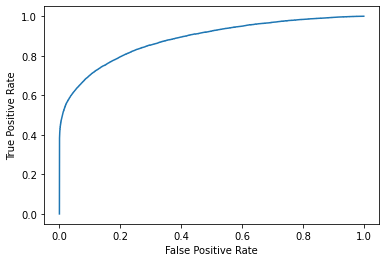

In [ ]:
plot_roc = RocCurveDisplay(fpr=fpr, tpr=tpr)
plot_roc.plot()

Selanjutnya, kami plot Precision-Recall Curve

In [ ]:
precision, recall, th_pr = precision_recall_curve(y_val, y_val_pred_proba)

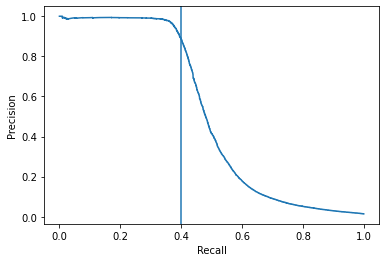

In [ ]:
plot_pr = PrecisionRecallDisplay(precision=precision, recall=recall)
plot_pr.plot()
plt.axvline(x=recall[np.argmax(recall <= 0.4)])
plt.show()

Terlihat pada plot di atas, precision terlihat menurun drastis ketika recall mencapai sekitar 0.4. Pada kasus ini, karena apabila recall tinggi, diperoleh precision yang sangat rendah, maka kami memutuskan untuk mengambil precision setidaknya 0.9.

Pada cell dibawah, kami ingin mencari berapa threshold yang menghasilkan precision setidaknya 0.9. Diperoleh precision yang cukup tinggi pada validation set dan f1-score yang baik. Sehingga akan digunakan model ini

In [ ]:
th_prec_09 = th_pr[np.argmax(precision > 0.9)]

print(classification_report(y_val, (y_val_pred_proba >= th_prec_09).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    899559
           1       0.90      0.40      0.55     12591

    accuracy                           0.99    912150
   macro avg       0.95      0.70      0.77    912150
weighted avg       0.99      0.99      0.99    912150



In [ ]:
th_prec_09

0.7788573797904184

In [ ]:
accuracy_score(y_val, (y_val_pred_proba >= th_prec_09).astype(int))

0.9910453324562846

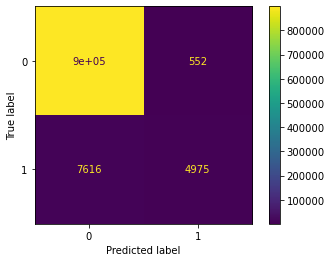

In [ ]:
cm3 = confusion_matrix(y_val, (y_val_pred_proba >= th_prec_09).astype(int))
disp = ConfusionMatrixDisplay(cm3, display_labels=model_pipeline.named_steps.lgbm.classes_)
disp.plot()
plt.show()

In [ ]:
cm3[0,0]/(cm3[0,0]+cm3[0,1])

0.9993863659859998

Cell dibawah berfungsi untuk membuat class estimator yang bisa memprediksi suatu data menggunakan threshold yang sudah ditentukan.

In [ ]:
class XGB_custom_th(BaseEstimator):
    def __init__(self, th=th_prec_09):
        self.th = th
        self.model = model_pipeline
    def fit(self):
        return self
    def predict(self, X):
        y_pred = self.model.predict_proba(X)[:, 1]
        return (y_pred >= self.th).astype(int)

In [ ]:
final_model = XGB_custom_th()
y_val_pred = final_model.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    899559
           1       0.90      0.40      0.55     12591

    accuracy                           0.99    912150
   macro avg       0.95      0.70      0.77    912150
weighted avg       0.99      0.99      0.99    912150



## Evaluation on Test Set dengan model Light GBM

In [ ]:
start = time.time()
y_test_pred = final_model.predict(X_test)
stop = time.time()
print('Light GBM Predict time on test set: {} seconds'.format(stop - start))
print(classification_report(y_test, y_test_pred))

Light GBM Predict time on test set: 398.96043038368225 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   6747001
           1       0.90      0.40      0.55     94120

    accuracy                           0.99   6841121
   macro avg       0.95      0.70      0.77   6841121
weighted avg       0.99      0.99      0.99   6841121



Terlihat dari hasil Light GBM diatas dan membandingkannya dengan evaluasi XGBoost, diperoleh bahwa keduanya tidak berbeda jauh, tetapi XGBoost menghasilkan metric yang lebih baik. Kekurangan pada XGBoost adalah waktu predict lebih lama sekitar 200 detik. Sehingga, dapat menjadi masalah jika data semakin membesar. Jika resource yang dipunya mencukupi, maka model XGBoost lebih baik digunakan, sebaliknya sebaiknya menggunakan Light GBM untuk mengurangi waktu komputasi.

Selanjutnya kami akan menggunakan XGBoost sebagai model final kami.

# Training dan Evaluasi model XGBoost final

## Training

Kami akan training ulang model XGBoost menggunakan data train yang lebih banyak, yaitu sebanyak 60% dari data keseluruhan.

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_prepared, y, test_size=.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((6841120, 777), (2280374, 777), (2280374, 777))

In [ ]:
es = xgb.callback.EarlyStopping(rounds=100, metric_name='auc', data_name='validation_0', maximize=True,
                                save_best=True)

model_pipeline = imbpipeline([
    ('over', SMOTE(sampling_strategy=0.19676221847208702, n_jobs=-1, k_neighbors=858)),
    ('under', RandomUnderSampler(sampling_strategy=0.8849275028627146)),
    ('xgb', xgb.XGBClassifier(n_estimators=1000, colsample_bytree=0.5, gamma=0, learning_rate=0.05377367769556463, 
                              max_depth=64, reg_alpha=1.8796306666826916, reg_lambda=0.01, 
                              subsample=1.0, min_child_weight=1, scale_pos_weight=1/0.8849275028627146,
                              callbacks=[es], objective='binary:logistic', eval_metric=['auc', 'logloss'],
                              verbosity=2, n_jobs=-1, tree_method='approx'))
])

In [ ]:
model_pipeline.fit(X_train, y_train, xgb__eval_set=[(X_val, y_val)])

[14:39:50] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[0]	validation_0-auc:0.68234	validation_0-logloss:0.64968
[14:40:12] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[1]	validation_0-auc:0.71335	validation_0-logloss:0.61010
[14:40:37] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[2]	validation_0-auc:0.84877	validation_0-logloss:0.57140
[14:41:01] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[3]	validation_0-auc:0.84403	validation_0-logloss:0.53981
[14:41:20] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[4]	validation_0-auc:0.85523	validation_0-logloss:0.50720
[14:4

[41]	validation_0-auc:0.88220	validation_0-logloss:0.11814
[14:55:10] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[42]	validation_0-auc:0.88239	validation_0-logloss:0.11572
[14:55:27] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[43]	validation_0-auc:0.88302	validation_0-logloss:0.11290
[14:56:00] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[44]	validation_0-auc:0.88403	validation_0-logloss:0.11006
[14:56:23] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[45]	validation_0-auc:0.88454	validation_0-logloss:0.10752
[14:56:42] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.


[82]	validation_0-auc:0.89184	validation_0-logloss:0.06853
[15:11:23] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[83]	validation_0-auc:0.89204	validation_0-logloss:0.06805
[15:11:48] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[84]	validation_0-auc:0.89204	validation_0-logloss:0.06777
[15:12:04] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[85]	validation_0-auc:0.89228	validation_0-logloss:0.06734
[15:12:22] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[86]	validation_0-auc:0.89250	validation_0-logloss:0.06694
[15:12:36] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.


[123]	validation_0-auc:0.89491	validation_0-logloss:0.06012
[15:23:15] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[124]	validation_0-auc:0.89495	validation_0-logloss:0.06001
[15:23:24] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[125]	validation_0-auc:0.89493	validation_0-logloss:0.05994
[15:23:37] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[126]	validation_0-auc:0.89505	validation_0-logloss:0.05983
[15:23:48] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[127]	validation_0-auc:0.89505	validation_0-logloss:0.05977
[15:23:56] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient In

[164]	validation_0-auc:0.89527	validation_0-logloss:0.05769
[15:29:52] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[165]	validation_0-auc:0.89528	validation_0-logloss:0.05766
[15:30:00] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[166]	validation_0-auc:0.89519	validation_0-logloss:0.05763
[15:30:09] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[167]	validation_0-auc:0.89518	validation_0-logloss:0.05761
[15:30:17] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[168]	validation_0-auc:0.89514	validation_0-logloss:0.05758
[15:30:26] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient In

[205]	validation_0-auc:0.89379	validation_0-logloss:0.05670
[15:35:54] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[206]	validation_0-auc:0.89377	validation_0-logloss:0.05669
[15:36:01] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[207]	validation_0-auc:0.89370	validation_0-logloss:0.05666
[15:36:11] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[208]	validation_0-auc:0.89369	validation_0-logloss:0.05665
[15:36:19] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
[209]	validation_0-auc:0.89363	validation_0-logloss:0.05663
[15:36:28] INFO: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient In

Pipeline(steps=[('over',
                 SMOTE(k_neighbors=858, n_jobs=-1,
                       sampling_strategy=0.19676221847208702)),
                ('under',
                 RandomUnderSampler(sampling_strategy=0.8849275028627146)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               callbacks=[<xgboost.callback.EarlyStopping object at 0x000002259945A730>],
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.5, ear...
                               gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.05377367769556463, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=64, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=1000, n_jobs=-1,
                               num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=1.8796306666826916,
                               reg_lambda=0.01, ...))])

In [ ]:
model_pipeline.named_steps.xgb.best_iteration

143

Diperoleh hasil evaluasi pada data validasi (tanpa threshold tuning) adalah seperti dibawah berikut.

In [ ]:
y_val_pred = model_pipeline.predict(X_val)

print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   2248940
           1       0.64      0.47      0.54     31434

    accuracy                           0.99   2280374
   macro avg       0.82      0.73      0.77   2280374
weighted avg       0.99      0.99      0.99   2280374



## Threshold Tuning

In [ ]:
precision, recall, th_pr = precision_recall_curve(y_val, y_val_pred_proba)

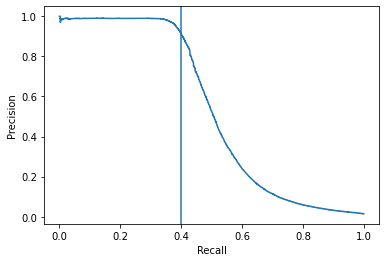

In [ ]:
plot_pr = PrecisionRecallDisplay(precision=precision, recall=recall)
plot_pr.plot()
plt.axvline(x=recall[np.argmax(recall <= 0.4)])
plt.show()

Akan digunakan threshold yang menghasilkan precision minimal 90% (sama seperti melakukan threshold tuning pada data train yang lebih sedikit pada section sebelumnya)

In [ ]:
th_prec_09 = th_pr[np.argmax(precision > 0.9)]

print(classification_report(y_val, (y_val_pred_proba >= th_prec_09).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00   2248940
           1       0.90      0.40      0.56     31434

    accuracy                           0.99   2280374
   macro avg       0.95      0.70      0.78   2280374
weighted avg       0.99      0.99      0.99   2280374



In [ ]:
th_prec_09

0.7868109

In [ ]:
accuracy_score(y_val, (y_val_pred_proba >= th_prec_09).astype(int))

0.9911711850775355

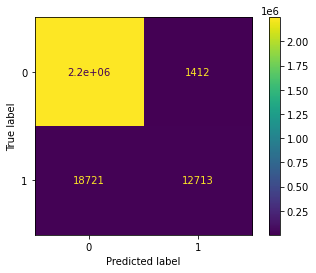

In [ ]:
cm3 = confusion_matrix(y_val, (y_val_pred_proba >= th_prec_09).astype(int), labels=model_pipeline.named_steps.xgb.classes_)
disp = ConfusionMatrixDisplay(cm3, display_labels=model_pipeline.named_steps.xgb.classes_)
disp.plot()
plt.show()

In [ ]:
# specificity
cm3[0,0]/(cm3[0,0]+cm3[0,1])

0.9993721486567005

In [ ]:
class XGB_custom_th(BaseEstimator):
    def __init__(self, th=th_prec_09):
        self.th = th
        self.model = model_pipeline
    def fit(self):
        return self
    def predict(self, X):
        y_pred = self.model.predict_proba(X)[:, 1]
        return (y_pred >= self.th).astype(int)

In [ ]:
final_model = XGB_custom_th()
y_val_pred = final_model.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00   2248940
           1       0.90      0.40      0.56     31434

    accuracy                           0.99   2280374
   macro avg       0.95      0.70      0.78   2280374
weighted avg       0.99      0.99      0.99   2280374



## Evaluation on Test Set model XGBoost Final

Dihasilkan metric yang lebih baik dibandingkan dengan ketika XGBoost di-train pada data yang lebih sedikit.

In [ ]:
y_test_pred = final_model.predict(X_test)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00   2248993
           1       0.91      0.41      0.56     31381

    accuracy                           0.99   2280374
   macro avg       0.95      0.70      0.78   2280374
weighted avg       0.99      0.99      0.99   2280374



# Prediksi data tahap 3

Sebelum melakukan prediksi data tahap 3, dilakukan hal serupa seperti sebelum kita melakukan modelling pada data train, yaitu Cleaning-Feature Engineering-Preprocessing.

In [ ]:
df_tahap3 = pd.read_csv('FINALLLL/sampling3_healthkathon2022_sep.csv', sep=';')
df_tahap3.head()

,id,id_peserta,dati2,typefaskes,usia,jenkel,pisat,tgldatang,tglpulang,jenispel,politujuan,diagfktp,biaya,jenispulang,cbg,kelasrawat,kdsa,kdsp,kdsr,kdsi,kdsd
0,3548,1,8,KL,67,L,1.0,2020-01-20T17:00:00.000Z,2020-01-20T17:00:00.000Z,2,INT,K21.9,187300.0,1,Q-5-44-0,3,None,None,None,None,None
1,85390,2,17,A,60,L,1.0,2019-02-06T17:00:00.000Z,2019-02-06T17:00:00.000Z,2,SAR,I63,381600.0,1,Q-5-44-0,3,None,None,None,None,None
2,89574,3,17,B,66,P,1.0,2019-12-11T17:00:00.000Z,2019-12-11T17:00:00.000Z,2,INT,E10.9,185500.0,1,Q-5-44-0,3,None,None,None,None,None
3,88653,4,17,B,52,P,1.0,2020-02-24T17:00:00.000Z,2020-02-24T17:00:00.000Z,2,SAR,M54.5,185500.0,1,Q-5-44-0,3,None,None,None,None,None
4,88634,5,17,B,63,L,2.0,2020-02-05T17:00:00.000Z,2020-02-05T17:00:00.000Z,2,JAN,I11.9,185500.0,1,Q-5-44-0,3,None,None,None,None,None


In [ ]:
df_diagnosa_tahap3 = pd.read_csv('FINALLLL/sampling3_healthkathon2022_diagnosa.csv', sep=';')
df_diagnosa_tahap3.head()

,id,kddiag,levelid
0,437398,F90.0,2
1,437401,H25.9,1
2,438542,A16.0,2
3,439298,Z09.8,1
4,439749,O48,1


In [ ]:
df_proc_tahap3 = pd.read_csv('FINALLLL/sampling3_healthkathon2022_procedure.csv', sep=';')
df_proc_tahap3.head()

,id,kdproc
0,2,74.0
1,2,88.78
2,2,90.59
3,7,90.59
4,10,90.59


In [ ]:
df_tahap3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099338 entries, 0 to 1099337
Data columns (total 21 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id           1099338 non-null  int64  
 1   id_peserta   1099338 non-null  int64  
 2   dati2        1099338 non-null  int64  
 3   typefaskes   1099338 non-null  object 
 4   usia         1099338 non-null  int64  
 5   jenkel       1099336 non-null  object 
 6   pisat        1099331 non-null  float64
 7   tgldatang    1099338 non-null  object 
 8   tglpulang    1099338 non-null  object 
 9   jenispel     1099338 non-null  int64  
 10  politujuan   981438 non-null   object 
 11  diagfktp     1099261 non-null  object 
 12  biaya        1093808 non-null  float64
 13  jenispulang  1099338 non-null  int64  
 14  cbg          1099338 non-null  object 
 15  kelasrawat   1099338 non-null  int64  
 16  kdsa         1075990 non-null  object 
 17  kdsp         1076062 non-null  object 
 18  kd

In [ ]:
df_diagnosa_tahap3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2209472 entries, 0 to 2209471
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   id       int64 
 1   kddiag   object
 2   levelid  int64 
dtypes: int64(2), object(1)
memory usage: 50.6+ MB


In [ ]:
df_tahap3.duplicated().sum()

0

In [ ]:
df_diagnosa_tahap3.duplicated().sum()

0

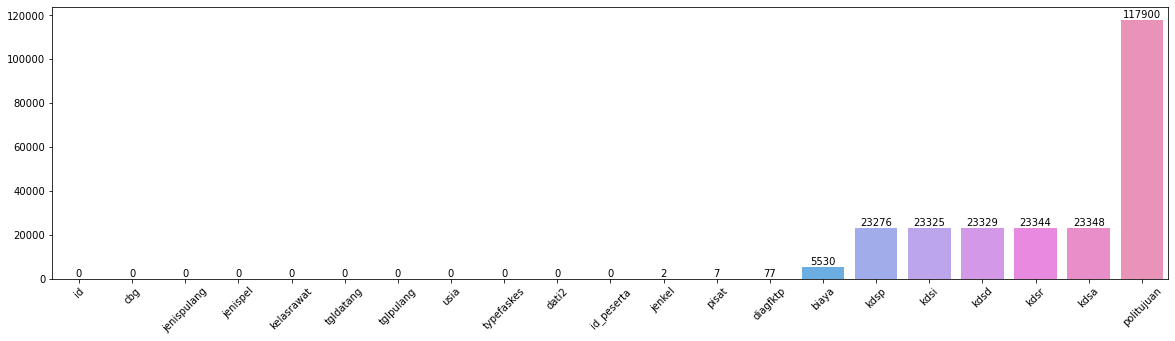

In [ ]:
plot_null(df_tahap3)

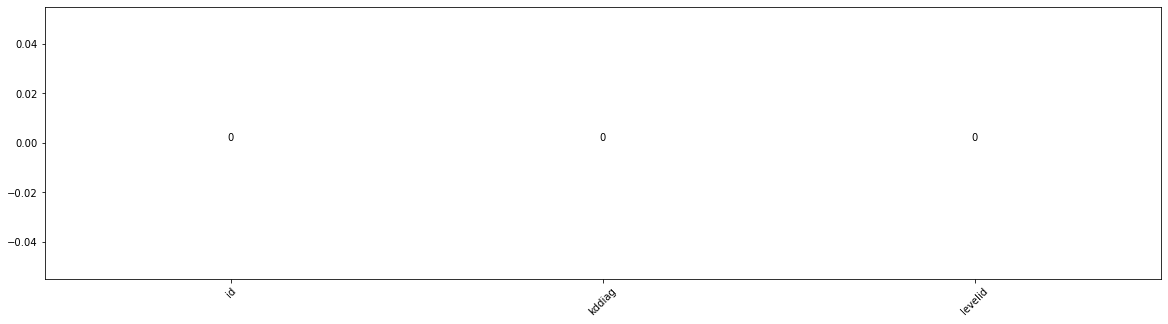

In [ ]:
plot_null(df_diagnosa_tahap3)

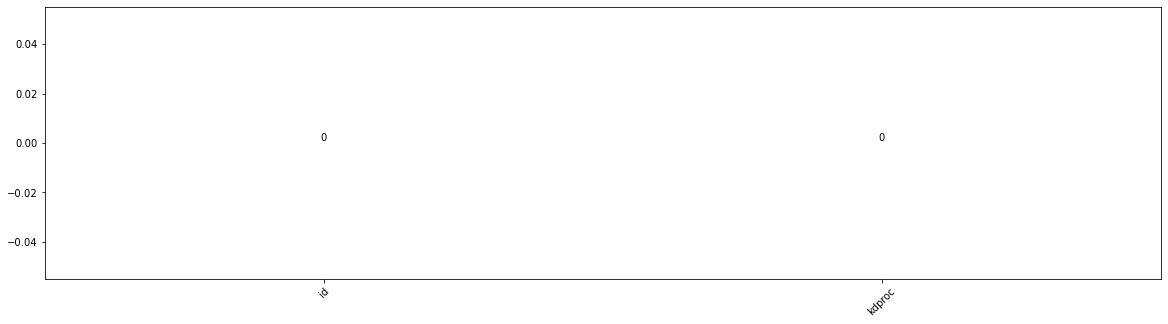

In [ ]:
plot_null(df_proc_tahap3)

## Data Cleaning

In [ ]:
df_tahap3.typefaskes.unique()

array(['KL', 'A ', 'B ', 'SA', 'SC', 'D ', 'SD', 'KI', 'C ', 'I2', 'KJ',
       'I4', 'SB', 'HD', 'I3', 'KM', 'KT', 'KC', 'KO', 'I1', 'GD', 'KG',
       'KB', 'KP', 'KU', 'KK'], dtype=object)

In [ ]:
df_tahap3.diagfktp.unique()

array(['K21.9', 'I63', 'E10.9', ..., 'p07.1', 'P02.4', 'p03.4'],
      dtype=object)

In [ ]:
df_tahap3.jenkel.unique()

array(['L', 'P', nan], dtype=object)

In [ ]:
df_tahap3.cbg.unique()

array(['Q-5-44-0', 'U-2-32-0', 'L-3-11-0', 'H-3-12-0', 'A-4-14-I',
       'M-3-16-0', 'Q-5-41-0', 'Z-3-23-0', 'Q-5-42-0', 'Q-5-32-0',
       'M-3-11-0', 'U-3-16-0', 'Z-3-12-0', 'J-3-13-0', 'J-4-16-I',
       'E-4-10-I', 'K-5-18-0', 'Z-3-27-0', 'K-4-17-III', 'Z-3-19-0',
       'A-4-13-I', 'D-3-10-0', 'L-3-12-0', 'Q-5-43-0', 'B-4-13-I',
       'J-4-20-I', 'N-3-15-0', 'Q-5-12-0', 'G-4-26-II', 'I-4-16-I',
       'K-4-18-II', 'M-1-80-I', 'N-1-20-III', 'U-3-15-0', 'Q-5-25-0',
       'K-4-12-II', 'H-1-30-I', 'K-4-18-I', 'M-1-20-I', 'Z-3-18-0',
       'I-4-14-II', 'G-4-24-I', 'C-3-11-0', 'K-4-13-I', 'G-4-23-I',
       'I-3-13-0', 'A-4-14-II', 'O-6-10-I', 'B-4-13-III', 'U-4-13-I',
       'D-4-13-I', 'I-3-14-0', 'Z-3-25-0', 'L-1-40-I', 'H-2-36-0',
       'F-4-10-I', 'A-4-12-I', 'K-4-17-I', 'I-4-17-I', 'G-4-17-I',
       'J-1-20-I', 'L-2-42-0', 'N-4-10-II', 'J-3-15-0', 'K-3-16-0',
       'H-3-11-0', 'E-4-10-II', 'U-1-20-I', 'U-1-15-I', 'I-4-17-III',
       'I-4-15-I', 'W-1-11-I', 'Q-5-27-0', 'J-4

In [ ]:
df_tahap3.kdsa.unique()

array(['None', nan, 'SF-4-10-III', 'SF-4-10-I', 'SF-4-13-III',
       'SF-4-10-X', 'SF-4-13-II', 'SF-4-13-I', 'SF-4-10-II',
       'SF-4-16-III', 'SA-4-14-III'], dtype=object)

In [ ]:
df_tahap3.kdsp.unique()

array(['None', nan, 'YY-10-III', 'YY-02-III', 'YY-06-III', 'YY-09-III',
       'YY-01-II', 'YY-11-III', 'YY-03-III', 'YY-07-III', 'YY-12-III',
       'YY-05-III', 'YY-04-III'], dtype=object)

In [ ]:
df_tahap3.kdsr.unique()

array(['None', nan, 'RR-04-III'], dtype=object)

In [ ]:
df_tahap3.kdsi.unique()

array(['None', nan, 'II-02-III', 'II-01-III', 'II-03-III'], dtype=object)

In [ ]:
df_tahap3.kdsd.unique()

array(['None', nan, 'DD-05-II', 'DD-01-I', 'DD-10-II', 'DD-07-II',
       'DD-06-II', 'DD-09-II', 'DD-02-II', 'DD-03-II', 'DD-04-II',
       'DD-08-II'], dtype=object)

In [ ]:
for obj_col in ['typefaskes', 'jenkel', 'politujuan', 'diagfktp', 'cbg', 'kdsa', 'kdsp', 'kdsr', 'kdsi', 'kdsd']:
    df_tahap3[obj_col] = df_tahap3[obj_col].str.strip()
    df_tahap3[obj_col] = df_tahap3[obj_col].str.upper()
    
    print(obj_col, 'DONE!')

typefaskes DONE!
jenkel DONE!
politujuan DONE!
diagfktp DONE!
cbg DONE!
kdsa DONE!
kdsp DONE!
kdsr DONE!
kdsi DONE!
kdsd DONE!


In [ ]:
df_tahap3['label'] = 0 # dummy
df_tahap3.shape

(1099338, 22)

In [ ]:
df_tahap3.drop('politujuan', axis=1, inplace=True)

In [ ]:
impute = joblib.load('impute.pkl')

In [ ]:
class to_df(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, arr):
        return self
    def transform(self, arr):
        return pd.DataFrame(arr, columns=['jenispulang', 'jenkel', 'pisat', 'diagfktp', 
                                          'kdsa', 'kdsp', 'kdsr', 'kdsi', 'kdsd', 'biaya', 'id', 'id_peserta', 
                                          'dati2', 'typefaskes', 'usia', 'tgldatang', 'tglpulang', 
                                          'jenispel', 'cbg', 'kelasrawat', 'label'])

In [ ]:
df_tahap3_prepared = impute.transform(df_tahap3)
df_tahap3_prepared = to_df().transform(df_tahap3_prepared)
df_tahap3_prepared.head()

,jenispulang,jenkel,pisat,diagfktp,kdsa,kdsp,kdsr,kdsi,kdsd,biaya,id,id_peserta,dati2,typefaskes,usia,tgldatang,tglpulang,jenispel,cbg,kelasrawat,label
0,1,L,1.0,K21.9,NONE,NONE,NONE,NONE,NONE,187300.0,3548,1,8,KL,67,2020-01-20T17:00:00.000Z,2020-01-20T17:00:00.000Z,2,Q-5-44-0,3,0
1,1,L,1.0,I63,NONE,NONE,NONE,NONE,NONE,381600.0,85390,2,17,A,60,2019-02-06T17:00:00.000Z,2019-02-06T17:00:00.000Z,2,Q-5-44-0,3,0
2,1,P,1.0,E10.9,NONE,NONE,NONE,NONE,NONE,185500.0,89574,3,17,B,66,2019-12-11T17:00:00.000Z,2019-12-11T17:00:00.000Z,2,Q-5-44-0,3,0
3,1,P,1.0,M54.5,NONE,NONE,NONE,NONE,NONE,185500.0,88653,4,17,B,52,2020-02-24T17:00:00.000Z,2020-02-24T17:00:00.000Z,2,Q-5-44-0,3,0
4,1,L,2.0,I11.9,NONE,NONE,NONE,NONE,NONE,185500.0,88634,5,17,B,63,2020-02-05T17:00:00.000Z,2020-02-05T17:00:00.000Z,2,Q-5-44-0,3,0


In [ ]:
p = df_tahap3_prepared.diagfktp
q = p.str.slice(1,3)

diagfktp_other = []
for i in q.index.values:
    try:
        int(q[i])
    except:
        diagfktp_other.append(p[i])
    
    if i%10**5 == 0:
        print('i =', i, 'DONE!')

diagfktp_other = np.array(diagfktp_other)
diagfktp_other = np.unique(diagfktp_other)

i = 0 DONE!
i = 100000 DONE!
i = 200000 DONE!
i = 300000 DONE!
i = 400000 DONE!
i = 500000 DONE!
i = 600000 DONE!
i = 700000 DONE!
i = 800000 DONE!
i = 900000 DONE!
i = 1000000 DONE!


In [ ]:
diagfktp_other

array(['-', '--', '34.89', 'NONE'], dtype='<U5')

In [ ]:
df_tahap3_prepared.diagfktp.value_counts()

Z09.8     90705
M54.5     21050
I50.0     20586
N18       17579
N18.9     16880
          ...  
M42.99        1
D022          1
A39.9         1
S70.0         1
P02.4         1
Name: diagfktp, Length: 10247, dtype: int64

In [ ]:
for val in diagfktp_other:
    df_tahap3_prepared.loc[df_tahap3_prepared.diagfktp == val, 'diagfktp'] = 'Z09.8'
    
    print(val, 'DONE!')

- DONE!
-- DONE!
34.89 DONE!
NONE DONE!


In [ ]:
p = df_tahap3_prepared.diagfktp
q = p.str.slice(0,1)

diagfktp_other = []
for i in q.index.values:
    if i%10**5 == 0:
        print('i =', i, 'running...')
        
    try:
        int(q[i])
        diagfktp_other.append(p[i])
    except:
        continue

diagfktp_other = np.array(diagfktp_other)
diagfktp_other = np.unique(diagfktp_other)
diagfktp_other

i = 0 running...
i = 100000 running...
i = 200000 running...
i = 300000 running...
i = 400000 running...
i = 500000 running...
i = 600000 running...
i = 700000 running...
i = 800000 running...
i = 900000 running...
i = 1000000 running...


array([], dtype=float64)

In [ ]:
df_tahap3_prepared['diagfktp'] = df_tahap3_prepared['diagfktp'].str.slice(0,3)
df_tahap3_prepared.head()

,jenispulang,jenkel,pisat,diagfktp,kdsa,kdsp,kdsr,kdsi,kdsd,biaya,id,id_peserta,dati2,typefaskes,usia,tgldatang,tglpulang,jenispel,cbg,kelasrawat,label
0,1,L,1.0,K21,NONE,NONE,NONE,NONE,NONE,187300.0,3548,1,8,KL,67,2020-01-20T17:00:00.000Z,2020-01-20T17:00:00.000Z,2,Q-5-44-0,3,0
1,1,L,1.0,I63,NONE,NONE,NONE,NONE,NONE,381600.0,85390,2,17,A,60,2019-02-06T17:00:00.000Z,2019-02-06T17:00:00.000Z,2,Q-5-44-0,3,0
2,1,P,1.0,E10,NONE,NONE,NONE,NONE,NONE,185500.0,89574,3,17,B,66,2019-12-11T17:00:00.000Z,2019-12-11T17:00:00.000Z,2,Q-5-44-0,3,0
3,1,P,1.0,M54,NONE,NONE,NONE,NONE,NONE,185500.0,88653,4,17,B,52,2020-02-24T17:00:00.000Z,2020-02-24T17:00:00.000Z,2,Q-5-44-0,3,0
4,1,L,2.0,I11,NONE,NONE,NONE,NONE,NONE,185500.0,88634,5,17,B,63,2020-02-05T17:00:00.000Z,2020-02-05T17:00:00.000Z,2,Q-5-44-0,3,0


In [ ]:
df_diagnosa_tahap3_primer = df_diagnosa_tahap3[df_diagnosa_tahap3.levelid == 1].copy()
df_diagnosa_tahap3_sekunder = df_diagnosa_tahap3[df_diagnosa_tahap3.levelid == 2].copy()

df_diagnosa_tahap3_primer.drop('levelid', axis=1, inplace=True)
df_diagnosa_tahap3_sekunder.drop('levelid', axis=1, inplace=True)

df_diagnosa_tahap3_primer.reset_index(inplace=True)
df_diagnosa_tahap3_sekunder.reset_index(inplace=True)
df_diagnosa_tahap3_primer = df_diagnosa_tahap3_primer[['id', 'kddiag']]
df_diagnosa_tahap3_sekunder = df_diagnosa_tahap3_sekunder[['id', 'kddiag']]

In [ ]:
df_diagnosa_tahap3_primer.id.duplicated().sum()

2

In [ ]:
df_diagnosa_tahap3_primer = df_diagnosa_tahap3_primer[~(df_diagnosa_tahap3_primer.id.duplicated(keep='last'))]

In [ ]:
df_diagnosa_tahap3_primer.id.duplicated().sum()

0

In [ ]:
df_diagnosa_tahap3_sekunder.duplicated().sum()

0

In [ ]:
df_diagnosa_tahap3_primer['kddiag'] = df_diagnosa_tahap3_primer['kddiag'].str.strip()
df_diagnosa_tahap3_primer['kddiag'] = df_diagnosa_tahap3_primer['kddiag'].str.upper()

In [ ]:
p = df_diagnosa_tahap3_primer.kddiag
q = p.str.slice(1,3)

diag_other = []
for i in q.index.values:
    try:
        int(q[i])
    except:
        diag_other.append(p[i])
    
    if i%10**5 == 0:
        print('i =', i, 'DONE!')

diag_other = np.unique(np.array(diag_other))
diag_other

i = 0 DONE!
i = 100000 DONE!
i = 200000 DONE!
i = 300000 DONE!
i = 400000 DONE!
i = 500000 DONE!
i = 600000 DONE!
i = 700000 DONE!
i = 800000 DONE!
i = 900000 DONE!
i = 1000000 DONE!


array([], dtype=float64)

In [ ]:
p = df_diagnosa_tahap3_primer.kddiag
q = p.str.slice(0,1)

diag_other = []
for i in q.index.values:
    if i%10**5 == 0:
        print('i =', i, 'running...')
        
    try:
        int(q[i])
        diag_other.append(p[i])
    except:
        continue

diag_other = np.unique(np.array(diag_other))
diag_other

i = 0 running...
i = 100000 running...
i = 200000 running...
i = 300000 running...
i = 400000 running...
i = 500000 running...
i = 600000 running...
i = 700000 running...
i = 800000 running...
i = 900000 running...
i = 1000000 running...


array([], dtype=float64)

In [ ]:
df_diagnosa_tahap3_primer['kddiag'] = df_diagnosa_tahap3_primer['kddiag'].str.slice(0,3)

In [ ]:
diag_sekunder_counts3 = df_diagnosa_tahap3_sekunder.id.value_counts()[df_diagnosa_tahap3_sekunder.id.values].to_numpy()
df_diagnosa_tahap3_sekunder['diag_sekunder_counts'] = diag_sekunder_counts3
df_diagnosa_tahap3_sekunder.head()

,id,kddiag,diag_sekunder_counts
0,437398,F90.0,1
1,438542,A16.0,1
2,440827,I11.9,1
3,446053,I64,2
4,453562,I64,1


In [ ]:
df_diagnosa_tahap3_sekunder.drop('kddiag', axis=1, inplace=True)
df_diagnosa_tahap3_sekunder.head()

,id,diag_sekunder_counts
0,437398,1
1,438542,1
2,440827,1
3,446053,2
4,453562,1


In [ ]:
df_diagnosa_tahap3_sekunder.duplicated().sum()

276586

In [ ]:
df_diagnosa_tahap3_sekunder.drop_duplicates(inplace=True)

In [ ]:
df_diagnosa_tahap3_prepared = df_diagnosa_tahap3_primer.merge(df_diagnosa_tahap3_sekunder, how='left', on='id')
df_diagnosa_tahap3_prepared.head()

,id,kddiag,diag_sekunder_counts
0,437401,H25,NaN
1,439298,Z09,1.0
2,439749,O48,5.0
3,441900,Z09,1.0
4,445502,Z09,2.0


In [ ]:
df_diagnosa_tahap3_prepared = pd.DataFrame(SimpleImputer(strategy='constant', fill_value=0).fit_transform(df_diagnosa_tahap3_prepared),
                                           columns=['id', 'diag', 'diag_sekunder_counts'])
df_diagnosa_tahap3_prepared.head()

,id,diag,diag_sekunder_counts
0,437401,H25,0
1,439298,Z09,1.0
2,439749,O48,5.0
3,441900,Z09,1.0
4,445502,Z09,2.0


In [ ]:
df_diagnosa_tahap3_prepared.isna().sum()

id                      0
diag                    0
diag_sekunder_counts    0
dtype: int64

In [ ]:
df_proc_tahap3.drop_duplicates(inplace=True)
df_proc_tahap3.duplicated().sum()

0

## Feature Engineering

In [ ]:
df_tahap3_prepared['tgldatang'] = pd.to_datetime(df_tahap3_prepared['tgldatang'])
df_tahap3_prepared['tglpulang'] = pd.to_datetime(df_tahap3_prepared['tglpulang'])
df_tahap3_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099338 entries, 0 to 1099337
Data columns (total 21 columns):
 #   Column       Non-Null Count    Dtype              
---  ------       --------------    -----              
 0   jenispulang  1099338 non-null  object             
 1   jenkel       1099338 non-null  object             
 2   pisat        1099338 non-null  object             
 3   diagfktp     1099338 non-null  object             
 4   kdsa         1099338 non-null  object             
 5   kdsp         1099338 non-null  object             
 6   kdsr         1099338 non-null  object             
 7   kdsi         1099338 non-null  object             
 8   kdsd         1099338 non-null  object             
 9   biaya        1099338 non-null  object             
 10  id           1099338 non-null  object             
 11  id_peserta   1099338 non-null  object             
 12  dati2        1099338 non-null  object             
 13  typefaskes   1099338 non-null  object     

In [ ]:
df_tahap3_prepared['lama_rawat'] = (df_tahap3_prepared['tglpulang'] - df_tahap3_prepared['tgldatang']).dt.days
df_tahap3_prepared.drop(['tgldatang', 'tglpulang'], axis=1, inplace=True)
df_tahap3_prepared.head()

,jenispulang,jenkel,pisat,diagfktp,kdsa,kdsp,kdsr,kdsi,kdsd,biaya,id,id_peserta,dati2,typefaskes,usia,jenispel,cbg,kelasrawat,label,lama_rawat
0,1,L,1.0,K21,NONE,NONE,NONE,NONE,NONE,187300.0,3548,1,8,KL,67,2,Q-5-44-0,3,0,0
1,1,L,1.0,I63,NONE,NONE,NONE,NONE,NONE,381600.0,85390,2,17,A,60,2,Q-5-44-0,3,0,0
2,1,P,1.0,E10,NONE,NONE,NONE,NONE,NONE,185500.0,89574,3,17,B,66,2,Q-5-44-0,3,0,0
3,1,P,1.0,M54,NONE,NONE,NONE,NONE,NONE,185500.0,88653,4,17,B,52,2,Q-5-44-0,3,0,0
4,1,L,2.0,I11,NONE,NONE,NONE,NONE,NONE,185500.0,88634,5,17,B,63,2,Q-5-44-0,3,0,0


In [ ]:
print('==========pisah cbg start=============')
cbg_CMG, cbg_tipekasus, cbg_spesifikkasus, cbg_severity = pisah_cbg('cbg', df_tahap3_prepared)
print('==========pisah kdsa start=============')
kdsa_CMG, kdsa_tipekasus, kdsa_spesifikkasus, kdsa_severity = pisah_cbg('kdsa', df_tahap3_prepared)
print('==========pisah kdsp start=============')
kdsp_CMG, kdsp_tipekasus, kdsp_spesifikkasus, kdsp_severity = pisah_cbg('kdsp', df_tahap3_prepared)
print('==========pisah kdsr start=============')
kdsr_CMG, kdsr_tipekasus, kdsr_spesifikkasus, kdsr_severity = pisah_cbg('kdsr', df_tahap3_prepared)
print('==========pisah kdsi start=============')
kdsi_CMG, kdsi_tipekasus, kdsi_spesifikkasus, kdsi_severity = pisah_cbg('kdsi', df_tahap3_prepared)
print('==========pisah kdsd start=============')
kdsd_CMG, kdsd_tipekasus, kdsd_spesifikkasus, kdsd_severity = pisah_cbg('kdsd', df_tahap3_prepared)

==========pisah cbg start=============
i = 0 DONE!
i = 1000000 DONE!
==========pisah kdsa start=============
i = 0 DONE!
i = 1000000 DONE!
==========pisah kdsp start=============
i = 0 DONE!
i = 1000000 DONE!
==========pisah kdsr start=============
i = 0 DONE!
i = 1000000 DONE!
==========pisah kdsi start=============
i = 0 DONE!
i = 1000000 DONE!
==========pisah kdsd start=============
i = 0 DONE!
i = 1000000 DONE!


In [ ]:
df_tahap3_prepared['cbg_CMG'] = cbg_CMG
df_tahap3_prepared['cbg_tipekasus'] = cbg_tipekasus
df_tahap3_prepared['cbg_spesifikkasus'] = cbg_spesifikkasus
df_tahap3_prepared['cbg_severity'] = cbg_severity
df_tahap3_prepared.drop('cbg', axis=1, inplace=True)

df_tahap3_prepared.head()

,jenispulang,jenkel,pisat,diagfktp,kdsa,kdsp,kdsr,kdsi,kdsd,biaya,id,id_peserta,dati2,typefaskes,usia,jenispel,kelasrawat,label,lama_rawat,cbg_CMG,cbg_tipekasus,cbg_spesifikkasus,cbg_severity
0,1,L,1.0,K21,NONE,NONE,NONE,NONE,NONE,187300.0,3548,1,8,KL,67,2,3,0,0,Q,5,44,0
1,1,L,1.0,I63,NONE,NONE,NONE,NONE,NONE,381600.0,85390,2,17,A,60,2,3,0,0,Q,5,44,0
2,1,P,1.0,E10,NONE,NONE,NONE,NONE,NONE,185500.0,89574,3,17,B,66,2,3,0,0,Q,5,44,0
3,1,P,1.0,M54,NONE,NONE,NONE,NONE,NONE,185500.0,88653,4,17,B,52,2,3,0,0,Q,5,44,0
4,1,L,2.0,I11,NONE,NONE,NONE,NONE,NONE,185500.0,88634,5,17,B,63,2,3,0,0,Q,5,44,0


In [ ]:
df_tahap3_prepared['kdsa_CMG'] = kdsa_CMG
df_tahap3_prepared['kdsa_tipekasus'] = kdsa_tipekasus
df_tahap3_prepared['kdsa_spesifikkasus'] = kdsa_spesifikkasus
df_tahap3_prepared['kdsa_severity'] = kdsa_severity
df_tahap3_prepared.drop('kdsa', axis=1, inplace=True)

df_tahap3_prepared.loc[~(df_tahap3_prepared.kdsa_severity.isin(['-', 'I', 'II', 'III'])), 'kdsa_severity'] = 'III'

df_tahap3_prepared['kdsp_spesifikkasus'] = kdsp_spesifikkasus
df_tahap3_prepared['kdsp_severity'] = kdsp_severity
df_tahap3_prepared.drop('kdsp', axis=1, inplace=True)

df_tahap3_prepared['kdsr_spesifikkasus'] = kdsr_spesifikkasus
df_tahap3_prepared['kdsr_severity'] = kdsr_severity
df_tahap3_prepared.drop('kdsr', axis=1, inplace=True)

df_tahap3_prepared['kdsi_spesifikkasus'] = kdsi_spesifikkasus
df_tahap3_prepared.drop('kdsi', axis=1, inplace=True)

df_tahap3_prepared['kdsd_spesifikkasus'] = kdsd_spesifikkasus
df_tahap3_prepared['kdsd_severity'] = kdsd_severity
df_tahap3_prepared.drop('kdsd', axis=1, inplace=True)

df_tahap3_prepared.head()

,jenispulang,jenkel,pisat,diagfktp,biaya,id,id_peserta,dati2,typefaskes,usia,jenispel,kelasrawat,label,lama_rawat,cbg_CMG,cbg_tipekasus,cbg_spesifikkasus,cbg_severity,kdsa_CMG,kdsa_tipekasus,kdsa_spesifikkasus,kdsa_severity,kdsp_spesifikkasus,kdsp_severity,kdsr_spesifikkasus,kdsr_severity,kdsi_spesifikkasus,kdsd_spesifikkasus,kdsd_severity
0,1,L,1.0,K21,187300.0,3548,1,8,KL,67,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-
1,1,L,1.0,I63,381600.0,85390,2,17,A,60,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-
2,1,P,1.0,E10,185500.0,89574,3,17,B,66,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-
3,1,P,1.0,M54,185500.0,88653,4,17,B,52,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-
4,1,L,2.0,I11,185500.0,88634,5,17,B,63,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-


In [ ]:
df_tahap3_prepared.drop('dati2', axis=1, inplace=True)

In [ ]:
df_tahap3_prepared['diagfktp_letter'] = df_tahap3_prepared.diagfktp.str.slice(0,1).to_numpy()
df_tahap3_prepared['diagfktp_num'] = df_tahap3_prepared.diagfktp.str.slice(1).to_numpy().astype(np.int64)
df_tahap3_prepared.drop('diagfktp', axis=1, inplace=True)

In [ ]:
df_diagnosa_tahap3_prepared['diagfkrtl_letter'] = df_diagnosa_tahap3_prepared.diag.str.slice(0,1).to_numpy()
df_diagnosa_tahap3_prepared['diagfkrtl_num'] = df_diagnosa_tahap3_prepared.diag.str.slice(1).to_numpy().astype(np.int64)
df_diagnosa_tahap3_prepared.drop('diag', axis=1, inplace=True)

df_diagnosa_tahap3_prepared.rename(columns={'diag_sekunder_counts':'diagfkrtl_sekunder_counts'}, inplace=True)
df_diagnosa_tahap3_prepared = df_diagnosa_tahap3_prepared[['id', 'diagfkrtl_letter', 'diagfkrtl_num', 'diagfkrtl_sekunder_counts']]
df_diagnosa_tahap3_prepared.head()

,id,diagfkrtl_letter,diagfkrtl_num,diagfkrtl_sekunder_counts
0,437401,H,25,0
1,439298,Z,9,1.0
2,439749,O,48,5.0
3,441900,Z,9,1.0
4,445502,Z,9,2.0


In [ ]:
df_tahap3_prepared = df_tahap3_prepared.merge(df_diagnosa_tahap3_prepared, how='left', on='id')

In [ ]:
df_tahap3_prepared.head()

,jenispulang,jenkel,pisat,biaya,id,id_peserta,typefaskes,usia,jenispel,kelasrawat,label,lama_rawat,cbg_CMG,cbg_tipekasus,cbg_spesifikkasus,cbg_severity,kdsa_CMG,kdsa_tipekasus,kdsa_spesifikkasus,kdsa_severity,kdsp_spesifikkasus,kdsp_severity,kdsr_spesifikkasus,kdsr_severity,kdsi_spesifikkasus,kdsd_spesifikkasus,kdsd_severity,diagfktp_letter,diagfktp_num,diagfkrtl_letter,diagfkrtl_num,diagfkrtl_sekunder_counts
0,1,L,1.0,187300.0,3548,1,KL,67,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,K,21,Z,9.0,1.0
1,1,L,1.0,381600.0,85390,2,A,60,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,I,63,Z,9.0,1.0
2,1,P,1.0,185500.0,89574,3,B,66,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,E,10,Z,9.0,2.0
3,1,P,1.0,185500.0,88653,4,B,52,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,M,54,Z,9.0,2.0
4,1,L,2.0,185500.0,88634,5,B,63,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,I,11,Z,9.0,1.0


In [ ]:
df_tahap3_prepared.isna().sum()

jenispulang                     0
jenkel                          0
pisat                           0
biaya                           0
id                              0
id_peserta                      0
typefaskes                      0
usia                            0
jenispel                        0
kelasrawat                      0
label                           0
lama_rawat                      0
cbg_CMG                         0
cbg_tipekasus                   0
cbg_spesifikkasus               0
cbg_severity                    0
kdsa_CMG                        0
kdsa_tipekasus                  0
kdsa_spesifikkasus              0
kdsa_severity                   0
kdsp_spesifikkasus              0
kdsp_severity                   0
kdsr_spesifikkasus              0
kdsr_severity                   0
kdsi_spesifikkasus              0
kdsd_spesifikkasus              0
kdsd_severity                   0
diagfktp_letter                 0
diagfktp_num                    0
diagfkrtl_lett

In [ ]:
diagfkrtl_letter_imputer = SimpleImputer(strategy='most_frequent')
df_tahap3_prepared['diagfkrtl_letter'] = diagfkrtl_letter_imputer.fit_transform(df_tahap3_prepared[['diagfkrtl_letter']])

diagfkrtl_num_imputer = SimpleImputer(strategy='median')
df_tahap3_prepared['diagfkrtl_num'] = diagfkrtl_num_imputer.fit_transform(df_tahap3_prepared[['diagfkrtl_num']])

diagfkrtl_sekunder_imputer = SimpleImputer(strategy='median')
df_tahap3_prepared['diagfkrtl_sekunder_counts'] = diagfkrtl_sekunder_imputer.fit_transform(df_tahap3_prepared[['diagfkrtl_sekunder_counts']])

In [ ]:
df_tahap3_prepared.isna().sum()

jenispulang                  0
jenkel                       0
pisat                        0
biaya                        0
id                           0
id_peserta                   0
typefaskes                   0
usia                         0
jenispel                     0
kelasrawat                   0
label                        0
lama_rawat                   0
cbg_CMG                      0
cbg_tipekasus                0
cbg_spesifikkasus            0
cbg_severity                 0
kdsa_CMG                     0
kdsa_tipekasus               0
kdsa_spesifikkasus           0
kdsa_severity                0
kdsp_spesifikkasus           0
kdsp_severity                0
kdsr_spesifikkasus           0
kdsr_severity                0
kdsi_spesifikkasus           0
kdsd_spesifikkasus           0
kdsd_severity                0
diagfktp_letter              0
diagfktp_num                 0
diagfkrtl_letter             0
diagfkrtl_num                0
diagfkrtl_sekunder_counts    0
dtype: i

In [ ]:
diagfktp_icd10 = []
for i in range(df_tahap3_prepared.shape[0]):
    letter = df_tahap3_prepared.loc[i, 'diagfktp_letter']
    num = df_tahap3_prepared.loc[i, 'diagfktp_num']
    if (letter in ['A', 'B']):
        diagfktp_icd10.append('I')
    elif (letter == 'C') or (letter == 'D' and num <= 48):
        diagfktp_icd10.append('II')
    elif letter == 'D' and num >= 50:
        diagfktp_icd10.append('III')
    elif letter == 'E':
        diagfktp_icd10.append('IV')
    elif letter == 'F':
        diagfktp_icd10.append('V')
    elif letter == 'G':
        diagfktp_icd10.append('VI')
    elif letter == 'H' and num <= 59:
        diagfktp_icd10.append('VII')
    elif letter == 'H' and num >= 60:
        diagfktp_icd10.append('VIII')
    elif letter == 'I':
        diagfktp_icd10.append('IX')
    elif letter == 'J':
        diagfktp_icd10.append('X')
    elif letter == 'K':
        diagfktp_icd10.append('XI')
    elif letter == 'L':
        diagfktp_icd10.append('XII')
    elif letter == 'M':
        diagfktp_icd10.append('XIII')
    elif letter == 'N':
        diagfktp_icd10.append('XIV')
    elif letter == 'O':
        diagfktp_icd10.append('XV')
    elif letter == 'P':
        diagfktp_icd10.append('XVI')
    elif letter == 'Q':
        diagfktp_icd10.append('XVII')
    elif letter == 'R':
        diagfktp_icd10.append('XVIII')
    elif letter in ['S', 'T']:
        diagfktp_icd10.append('XIX')
    elif letter in ['V', 'X', 'Y']:
        diagfktp_icd10.append('XX')
    elif letter == 'Z':
        diagfktp_icd10.append('XXI')
    else:
        diagfktp_icd10.append('XXII')
        
    if i%10**5 == 0:
        print('i =', i, 'DONE!')

i = 0 DONE!
i = 100000 DONE!
i = 200000 DONE!
i = 300000 DONE!
i = 400000 DONE!
i = 500000 DONE!
i = 600000 DONE!
i = 700000 DONE!
i = 800000 DONE!
i = 900000 DONE!
i = 1000000 DONE!


In [ ]:
diagfkrtl_icd10 = []
for i in range(df_tahap3_prepared.shape[0]):
    letter = df_tahap3_prepared.loc[i, 'diagfkrtl_letter']
    num = df_tahap3_prepared.loc[i, 'diagfkrtl_num']
    if (letter in ['A', 'B']):
        diagfkrtl_icd10.append('I')
    elif (letter == 'C') or (letter == 'D' and num <= 48):
        diagfkrtl_icd10.append('II')
    elif letter == 'D' and num >= 50:
        diagfkrtl_icd10.append('III')
    elif letter == 'E':
        diagfkrtl_icd10.append('IV')
    elif letter == 'F':
        diagfkrtl_icd10.append('V')
    elif letter == 'G':
        diagfkrtl_icd10.append('VI')
    elif letter == 'H' and num <= 59:
        diagfkrtl_icd10.append('VII')
    elif letter == 'H' and num >= 60:
        diagfkrtl_icd10.append('VIII')
    elif letter == 'I':
        diagfkrtl_icd10.append('IX')
    elif letter == 'J':
        diagfkrtl_icd10.append('X')
    elif letter == 'K':
        diagfkrtl_icd10.append('XI')
    elif letter == 'L':
        diagfkrtl_icd10.append('XII')
    elif letter == 'M':
        diagfkrtl_icd10.append('XIII')
    elif letter == 'N':
        diagfkrtl_icd10.append('XIV')
    elif letter == 'O':
        diagfkrtl_icd10.append('XV')
    elif letter == 'P':
        diagfkrtl_icd10.append('XVI')
    elif letter == 'Q':
        diagfkrtl_icd10.append('XVII')
    elif letter == 'R':
        diagfkrtl_icd10.append('XVIII')
    elif letter in ['S', 'T']:
        diagfkrtl_icd10.append('XIX')
    elif letter in ['V', 'X', 'Y']:
        diagfkrtl_icd10.append('XX')
    elif letter == 'Z':
        diagfkrtl_icd10.append('XXI')
    else:
        diagfkrtl_icd10.append('XXII')
        
    if i%10**5 == 0:
        print('i =', i, 'DONE!')

i = 0 DONE!
i = 100000 DONE!
i = 200000 DONE!
i = 300000 DONE!
i = 400000 DONE!
i = 500000 DONE!
i = 600000 DONE!
i = 700000 DONE!
i = 800000 DONE!
i = 900000 DONE!
i = 1000000 DONE!


In [ ]:
df_tahap3_prepared['diagfktp_icd10'] = diagfktp_icd10
df_tahap3_prepared['diagfkrtl_icd10'] = diagfkrtl_icd10

df_tahap3_prepared.drop(['diagfktp_letter', 'diagfktp_num', 'diagfkrtl_letter', 'diagfkrtl_num'], axis=1, inplace=True)
df_tahap3_prepared.head()

,jenispulang,jenkel,pisat,biaya,id,id_peserta,typefaskes,usia,jenispel,kelasrawat,label,lama_rawat,cbg_CMG,cbg_tipekasus,cbg_spesifikkasus,cbg_severity,kdsa_CMG,kdsa_tipekasus,kdsa_spesifikkasus,kdsa_severity,kdsp_spesifikkasus,kdsp_severity,kdsr_spesifikkasus,kdsr_severity,kdsi_spesifikkasus,kdsd_spesifikkasus,kdsd_severity,diagfkrtl_sekunder_counts,diagfktp_icd10,diagfkrtl_icd10
0,1,L,1.0,187300.0,3548,1,KL,67,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,1.0,XI,XXI
1,1,L,1.0,381600.0,85390,2,A,60,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,1.0,IX,XXI
2,1,P,1.0,185500.0,89574,3,B,66,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,2.0,IV,XXI
3,1,P,1.0,185500.0,88653,4,B,52,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,2.0,XIII,XXI
4,1,L,2.0,185500.0,88634,5,B,63,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,1.0,IX,XXI


In [ ]:
df_tahap3_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1099338 entries, 0 to 1099337
Data columns (total 30 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   jenispulang                1099338 non-null  object 
 1   jenkel                     1099338 non-null  object 
 2   pisat                      1099338 non-null  object 
 3   biaya                      1099338 non-null  object 
 4   id                         1099338 non-null  object 
 5   id_peserta                 1099338 non-null  object 
 6   typefaskes                 1099338 non-null  object 
 7   usia                       1099338 non-null  object 
 8   jenispel                   1099338 non-null  object 
 9   kelasrawat                 1099338 non-null  object 
 10  label                      1099338 non-null  object 
 11  lama_rawat                 1099338 non-null  int64  
 12  cbg_CMG                    1099338 non-null  object 
 13  cbg_tipekasu

In [ ]:
df_proc_tahap3_prepared = pd.DataFrame({'id': df_proc_tahap3.id.value_counts().index,
                                        'proc_count': df_proc_tahap3.id.value_counts()})

In [ ]:
df_proc_tahap3_prepared

,id,proc_count
1052875,1052875,33
1050625,1050625,30
1050950,1050950,29
1051388,1051388,23
1053012,1053012,22
...,...,...
444660,444660,1
444659,444659,1
444658,444658,1
444657,444657,1


In [ ]:
df_proc_tahap3_prepared.duplicated().sum()

0

In [ ]:
df_tahap3_prepared = df_tahap3_prepared.merge(df_proc_tahap3_prepared, how='left', on='id')

In [ ]:
df_tahap3_prepared.head()

,jenispulang,jenkel,pisat,biaya,id,id_peserta,typefaskes,usia,jenispel,kelasrawat,label,lama_rawat,cbg_CMG,cbg_tipekasus,cbg_spesifikkasus,cbg_severity,kdsa_CMG,kdsa_tipekasus,kdsa_spesifikkasus,kdsa_severity,kdsp_spesifikkasus,kdsp_severity,kdsr_spesifikkasus,kdsr_severity,kdsi_spesifikkasus,kdsd_spesifikkasus,kdsd_severity,diagfkrtl_sekunder_counts,diagfktp_icd10,diagfkrtl_icd10,proc_count
0,1,L,1.0,187300.0,3548,1,KL,67,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,1.0,XI,XXI,NaN
1,1,L,1.0,381600.0,85390,2,A,60,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,1.0,IX,XXI,NaN
2,1,P,1.0,185500.0,89574,3,B,66,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,2.0,IV,XXI,NaN
3,1,P,1.0,185500.0,88653,4,B,52,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,2.0,XIII,XXI,NaN
4,1,L,2.0,185500.0,88634,5,B,63,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,1.0,IX,XXI,NaN


In [ ]:
df_tahap3_prepared.isna().sum()

jenispulang                       0
jenkel                            0
pisat                             0
biaya                             0
id                                0
id_peserta                        0
typefaskes                        0
usia                              0
jenispel                          0
kelasrawat                        0
label                             0
lama_rawat                        0
cbg_CMG                           0
cbg_tipekasus                     0
cbg_spesifikkasus                 0
cbg_severity                      0
kdsa_CMG                          0
kdsa_tipekasus                    0
kdsa_spesifikkasus                0
kdsa_severity                     0
kdsp_spesifikkasus                0
kdsp_severity                     0
kdsr_spesifikkasus                0
kdsr_severity                     0
kdsi_spesifikkasus                0
kdsd_spesifikkasus                0
kdsd_severity                     0
diagfkrtl_sekunder_counts   

In [ ]:
df_tahap3_prepared.loc[df_tahap3_prepared.proc_count.isna(), 'proc_count'] = 0

In [ ]:
df_tahap3_prepared.head()

,jenispulang,jenkel,pisat,biaya,id,id_peserta,typefaskes,usia,jenispel,kelasrawat,label,lama_rawat,cbg_CMG,cbg_tipekasus,cbg_spesifikkasus,cbg_severity,kdsa_CMG,kdsa_tipekasus,kdsa_spesifikkasus,kdsa_severity,kdsp_spesifikkasus,kdsp_severity,kdsr_spesifikkasus,kdsr_severity,kdsi_spesifikkasus,kdsd_spesifikkasus,kdsd_severity,diagfkrtl_sekunder_counts,diagfktp_icd10,diagfkrtl_icd10,proc_count
0,1,L,1.0,187300.0,3548,1,KL,67,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,1.0,XI,XXI,0.0
1,1,L,1.0,381600.0,85390,2,A,60,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,1.0,IX,XXI,0.0
2,1,P,1.0,185500.0,89574,3,B,66,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,2.0,IV,XXI,0.0
3,1,P,1.0,185500.0,88653,4,B,52,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,2.0,XIII,XXI,0.0
4,1,L,2.0,185500.0,88634,5,B,63,2,3,0,0,Q,5,44,0,-,-,-,-,-,-,-,-,-,-,-,1.0,IX,XXI,0.0


In [ ]:
df_tahap3_prepared.isna().sum().sum()

0

## Preprocessing

In [ ]:
X_tahap3 = df_tahap3_prepared.drop(['id', 'id_peserta', 'label'], axis=1)

In [ ]:
X_tahap3_prepared = preprocess.transform(X_tahap3)

In [ ]:
X_tahap3_prepared

<1099338x777 sparse matrix of type '<class 'numpy.float64'>'
	with 24115956 stored elements in Compressed Sparse Row format>

## Predict data tahap 3 dengan model XGBoost final

In [ ]:
df_tahap3.shape

(1099338, 21)

In [ ]:
y_tahap3 = final_model.predict(X_tahap3_prepared)
y_tahap3

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y_tahap3.sum(), (1-y_tahap3).sum(), y_tahap3.sum()/y_tahap3.shape[0]

(6475, 1092863, 0.005889908290261958)

In [ ]:
answer_dict = {'id': df_tahap3.id.values,
              'label': y_tahap3}
answer = pd.DataFrame(answer_dict)
answer

,id,label
0,3548,0
1,85390,0
2,89574,0
3,88653,0
4,88634,0
...,...,...
1099333,455269,0
1099334,1006349,0
1099335,1093249,0
1099336,1003715,0


In [ ]:
answer.to_csv('answer.csv', index=False)